In [3]:
!pip install tensorflow-gpu==2.1.0

     |████████████████████████████████| 421.8MB 35kB/s 
     |████████████████████████████████| 450kB 51.6MB/s 
     |████████████████████████████████| 3.9MB 46.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=13238d403e470cad8f8d3b3633d56c70fca2f9fff954a2b8c993645eda8fb456
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import itertools
import math

def readdata(filename):
    df = pd.read_csv(filename, delimiter = "\t")
    data, sumarised = get_arranged(df)
    users = list(sumarised.userID)
    tdp = list(data.userID)
    #datafind = modulate(data)
    print(f"total data points: {len(tdp)}, total unique students: {len(users)}\n")
    return data, sumarised#, datafind

def readdata2(filename):
    df = pd.read_csv(filename, delimiter = ",")
    df["cumulative_avg"] = df["cumulative_avg"].apply(lambda x: 0 if np.isnan(x) else x)
    df["s_"] = df["s"]
    df.drop("s", inplace = True, axis = 1)
    df.drop("Unnamed: 0", inplace = True, axis = 1)
    df["s"] = df["s_"]
    df.drop("s_", inplace = True, axis = 1)
    df = df.fillna(0)
    ldf = list(df.userID)
    print(f"total data points: {len(ldf)}\n")
    return df

def readdata_v(filename):
    df = pd.read_csv(filename, delimiter = "\t")
    data, sumarised = get_VidID(df)
    users = list(sumarised.VidID)
    tdp = list(data.VidID)
    print(f"total data points: {len(tdp)}, total unique: {len(users)}\n")
    return data, sumarised

def normalize(data, m = np.array([None]), s = np.array([None])):
    #print(np.any(m == None))
    if np.any(m == None):
        m = []
        for col in range(data.shape[-1]):
            m.append(np.mean(data[:, col]))
        m = np.array(m)
    if np.any(s == None):
        s = []
        for col in range(data.shape[-1]):
            s.append(np.std(data[:, col]))
        s = np.array(s)
    return (data - m)/s, m, s

def get_arranged(df):
    ndf = df.sort_values("userID")
    cols = dict()
    for col in ndf.columns[1:]:
        if col == "VidID":
            cols[col] = list
        elif col == 's':
            cols[col] = np.sum
        else:
            cols[col] = np.mean
    maxvids = max(df.VidID) + 1
    #colapdf = df[df.duplicated("userID", keep=False)].groupby("userID").agg(cols).reset_index()
    colapdf = df.groupby("userID").agg(cols).reset_index()
    colapdf['vidsWatched'] = colapdf["VidID"].str.len()
    colapdf['vids_gt_5'] = colapdf["vidsWatched"].apply(lambda x: x if x >= 5 else math.inf)
    colapdf['s_avg'] = colapdf["s"].apply(lambda x: x/maxvids)
    colapdf['s_rel_avg'] = colapdf["s"]/(colapdf["vids_gt_5"]) # given you watched n videos, what was your avg on the vids you watched
    colapdf['s_tot_avg'] = colapdf["s"]/maxvids
    colapdf.drop("vids_gt_5", inplace = True, axis = 1)
    return ndf, colapdf

def modulate(df):
    keys = list(set(list(df.userID)))
    findf = []
    for key in keys:
        mask = df.groupby('userID')['userID'].transform(lambda x: x == key)
        dfn = df[mask].sort_values("VidID")
        dfn["cumulative_vids"] = 1
        dfn["cumulative_vids"] = dfn["cumulative_vids"].cumsum()
        dfn["cumulative_vids"] = dfn["cumulative_vids"] - 1

        dfn["shift_s"] = dfn['s'].shift(1).fillna(0)

        dfn["cumulative_s"] = dfn['s'].shift(1)
        dfn["cumulative_s"] = dfn["cumulative_s"].fillna(0)
        dfn["cumulative_s"] = dfn['s'].cumsum()
        dfn["cumulative_s"] = dfn["cumulative_s"] - dfn['s']
        dfn["cumulative_avg"] = dfn["cumulative_s"]/dfn["cumulative_vids"]


    #if type(findf) == type(None):
        findf.append(dfn)
        
        #subdifs.append(dfn)
    findf = pd.concat(findf)

    xv = findf.to_numpy()
    print (xv.shape)
    return findf


def get_VidID(df):
    ndf = df[df.duplicated("VidID", keep=False)].sort_values("VidID")
    cols = dict()
    for col in ndf.columns[:]:
        if col != 'VidID':
            if col == "userID":
                cols[col] = list
            else:
                cols[col] = np.sum
    colapdf = df[df.duplicated("VidID", keep=False)].groupby("VidID").agg(cols).reset_index()
    colapdf['studentsWatched'] = colapdf["userID"].str.len()
    colapdf.drop("userID", inplace = True, axis = 1)
    colapdf['s_avg'] = colapdf["s"]/colapdf['studentsWatched']
    for col in colapdf.columns[:]:
        if col != 'VidID' and col != 's_avg' and col != 's' and col != 'studentsWatched':
            colapdf[col] = colapdf[col]/colapdf['studentsWatched']
    return ndf, colapdf

#use distribution estimation to detrmine the distibution that each col follows. hw 3
def plot_df(data, filename = None, normal = False, rs = None, cs = None, kernel=['gau'], kde = True, histdist = True, relplots = True, pp = False):
    if filename != None:
        save = data.set_index(data.columns[0])
        save.to_csv(filename, sep = "\t")

    if rs != None and cs != None:
        fig = plt.figure()
        pallete = itertools.cycle(sns.color_palette())
        j = 0

    if histdist:
        shade = False
    else:
        shade = True
    
    for i, key in enumerate(data.columns[2:]):
        if normal:
            dp = normalize(data[key])
        else:
            dp = data[key]
        if (rs == None and cs == None):
            if kde:
                sns.kdeplot(dp, shade = shade)
            if histdist:
                sns.distplot(dp)
        else:
            axes = fig.add_subplot(rs, cs, i + 1)
            c = next(pallete)
            if kde:
                for kern in kernel:
                    sns.kdeplot(dp, shade = shade, ax = axes, kernel=kern, color = c)
                    #estimates ppf using gaussian kernal domain estimation
            if histdist:
                sns.distplot(dp, ax = axes, color = c)
            j = i
    if (rs != None and cs != None and relplots):
        j += 1
        c = next(pallete)
        try:
            with sns.axes_style('white'):
                plot_key = 's_rel_avg'
                for i, key in enumerate(data.columns[2:]):
                    #sns.jointplot('s_rel_avg', 'vidsWatched', data, kind = 'kde', color = next(pallete))
                    if key != plot_key:
                        #sns.jointplot('s_rel_avg', 'vidsWatched', data, kind = 'reg', color = next(pallete))
                        sns.jointplot(plot_key, key, data, kind = 'reg', color = next(pallete))
                        #sns.jointplot( 'fracComp', 's_rel_avg', data, kind = 'reg', color = next(pallete))
        except:
            with sns.axes_style('white'):
                sns.jointplot('s', 'fracPlayed', data, kind = 'reg', color = next(pallete)) # fraction of videos competed
                sns.jointplot('fracComp', 'fracSpent', data, kind = 'reg', color = next(pallete)) # undefined relation
                sns.jointplot('s', 'studentsWatched', data, kind = 'reg', color = next(pallete))
    if pp:
        temp = data.drop(data.columns[0:1], axis = 1)
        sns.pairplot(temp, kind = 'reg' , diag_kind = 'kde', height=10)
    plt.show()
    pass

def dist_data(data, rs = None, cs = None, k = 0):
    fig = plt.figure()
    pallete = itertools.cycle(sns.color_palette())
    j = 0
    dists = ['norm', 'cauchy', 'cosine', 'expon', 'uniform', 'laplace', 'wald', 'rayleigh']
    for i, key in enumerate(data.columns[2:]):
        axes = fig.add_subplot(rs, cs, i + 1)
        c = next(pallete)
        datavals = stats.probplot(data[key], plot=axes, dist = dists[k])
    plt.show()
    pass

def norm_df(df):
    means = []
    stds = []
    for i, key in enumerate(df.columns[2:]):
        means.append(np.mean(df[key]))
        stds.append(np.std(df[key]))
        df[key] = df[key].apply(lambda x : (x - np.mean(df[key]))/np.std(df[key]))
    return means, stds, df
    
def main():
    data, sumarised = readdata("behavior-performance.txt")
    #print (data.columns[2:])

    kernels = ['gau', 'cos', 'tri', 'epa', 'biw', 'triw']
    #plot_df(sumarised, rs = 4, cs = 4, histdist = False, relplots = False)
    return sumarised, data

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
# import tensorflow as tf 
# import tensorflow.keras as keras

# from tensorflow.keras import Model

# # model = keras.Sequential([
# #     keras.layers.Dense(x_train.shape[-1], input_shape = (x_train.shape[-1],)),
# #     keras.layers.Dense(512, activation = 'relu'), 
# #     keras.layers.Dense(256, activation = 'relu'),
# #     keras.layers.Dense(128, activation = 'relu'),
# #     keras.layers.Dense(64, activation = 'relu'),
# #     keras.layers.Dense(2, activation = 'softmax'),
# # ])

# dft, dfs = readdata("behavior-performance.txt")
# df_full = modulate(dft)
# df_full.to_csv("helpme.csv")


total data points: 29304, total unique students: 3976

(29304, 16)


In [24]:
# df_full = readdata2("helpme.csv")
# df_full.head(50)

total data points: 29304



,userID,VidID,fracSpent,fracComp,fracPlayed,fracPaused,numPauses,avgPBR,stdPBR,numRWs,numFFs,cumulative_vids,shift_s,cumulative_s,cumulative_avg,s
0,ff61169c30cf55070593322a09d29f77ef3653da,31,1.011806,0.994626,0.994626,0.000000,0,1.000000,0.000000e+00,0,0,0,0.0,0,0.000000,0
1,527c7585c71cfb2b6187fc011c270f1de1b4baee,3,0.996399,0.995625,0.995625,0.057862,1,1.000000,0.000000e+00,0,0,0,0.0,0,0.000000,1
2,527c7585c71cfb2b6187fc011c270f1de1b4baee,4,1.071294,0.446592,1.070739,3.412877,2,1.000000,0.000000e+00,4,0,1,1.0,1,1.000000,0
3,527c7585c71cfb2b6187fc011c270f1de1b4baee,5,0.997421,0.996568,0.996568,0.718360,2,1.000000,0.000000e+00,0,0,2,0.0,1,0.500000,1
4,527c7585c71cfb2b6187fc011c270f1de1b4baee,6,259.262453,0.996058,0.996058,0.063763,1,1.000000,0.000000e+00,0,0,3,1.0,2,0.666667,1
5,527c7585c71cfb2b6187fc011c270f1de1b4baee,7,1.000141,0.993634,0.993634,1.060737,1,1.000000,0.000000e+00,0,0,4,1.0,3,0.750000,0
6,527c7585c71cfb2b6187fc011c270f1de1b4baee,8,542.745431,0.497366,1.394020,14.361569,8,1.000000,0.000000e+00,5,5,5,0.0,3,0.600000,0
7,527c7585c71cfb2b6187fc011c270f1de1b4baee,9,64.713968,0.995969,0.995969,0.000000,0,1.000000,0.000000e+00,0,0,6,0.0,3,0.500000,0
8,527c7585c71cfb2b6187fc011c270f1de1b4baee,10,153.488600,0.992529,0.992529,0.000000,0,1.000000,0.000000e+00,0,0,7,0.0,3,0.428571,0
9,527c7585c71cfb2b6187fc011c270f1de1b4baee,11,0.831504,0.653063,1.251944,3.551815,6,1.513288,7.403064e-02,9,3,8,0.0,3,0.375000,1


In [0]:
dft = readdata2("idontwanttoprocessyouagain.csv")
#temp = dft.drop(dft.columns[0:1], axis = 1)
#sns.pairplot(temp, kind = 'reg' , diag_kind = 'kde', height=10)
dft.head(100)

total data points: 29304



,userID,VidID,fracSpent,fracComp,fracPlayed,fracPaused,numPauses,avgPBR,stdPBR,numRWs,numFFs,cumulative_vids,cumulative_s,cumulative_avg,s
0,4ebc23326db1f4f089985578d7dec848283afd9b,0,0.996378,0.995494,0.995494,0.118094,1,1.0,0.0,0,0,0,0,0.000000,1
1,4ebc23326db1f4f089985578d7dec848283afd9b,1,1.085443,0.672933,1.085320,0.000000,0,1.0,0.0,2,0,1,1,1.000000,1
2,4ebc23326db1f4f089985578d7dec848283afd9b,2,0.993226,0.991510,0.991510,7.021200,2,1.0,0.0,0,0,2,2,1.000000,1
3,4ebc23326db1f4f089985578d7dec848283afd9b,3,0.996950,0.995659,0.995659,0.048040,1,1.0,0.0,0,0,3,3,1.000000,1
4,4ebc23326db1f4f089985578d7dec848283afd9b,4,8.667519,0.996355,0.996355,0.071882,1,1.0,0.0,0,0,4,4,1.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,32f96a86b91388217b1afd7dc05c7f7ca4f2dca5,56,0.619939,0.015322,0.616286,0.010127,2,1.0,0.0,96,75,42,30,0.714286,0
96,32f96a86b91388217b1afd7dc05c7f7ca4f2dca5,57,0.578207,0.571886,0.571886,0.039616,2,1.0,0.0,0,0,43,30,0.697674,1
97,32f96a86b91388217b1afd7dc05c7f7ca4f2dca5,58,0.670032,0.665664,0.665664,824.961058,2,1.0,0.0,0,0,44,31,0.704545,0
98,32f96a86b91388217b1afd7dc05c7f7ca4f2dca5,59,0.773296,0.115309,0.769607,0.264813,8,1.0,0.0,114,41,45,31,0.688889,1


In [0]:
dftv, dfsv = readdata("behavior-performance.txt")
dfsv.head()

total data points: 29304, total unique students: 3976



,userID,VidID,fracSpent,fracComp,fracPlayed,fracPaused,numPauses,avgPBR,stdPBR,numRWs,numFFs,s,vidsWatched,s_avg,s_rel_avg,s_tot_avg
0,0002a8040dd93a3b460539c4eaa0e78750da40dd,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",1.075130,0.702957,0.950505,15.291605,1.533333,1.000000,0.000000,0.733333,0.333333,14,15,0.150538,0.933333,0.150538
1,000d165a33bd778527872a19d05cbf054e2abb66,"[0, 6, 21]",1.691928,0.705346,1.691651,1.714910,5.666667,1.000000,0.000000,12.666667,0.666667,3,3,0.032258,0.000000,0.032258
2,0017ef926fb44097f09150723612a5c2d5cc4af9,"[0, 6, 7, 8]",0.673139,0.995355,0.995355,0.035862,1.000000,1.489722,0.060833,0.000000,0.000000,3,4,0.032258,0.000000,0.032258
3,002f8b1d451bb4d271af262007d03282f243d511,"[6, 7, 21]",1.062922,0.919525,1.063515,0.426684,2.333333,1.000000,0.000000,2.333333,1.333333,2,3,0.021505,0.000000,0.021505
4,003542c629d2b523bc26f33dc3b9238898499cf5,"[26, 27]",1.004801,0.993964,0.993964,0.033033,0.500000,1.000000,0.000000,0.000000,0.000000,2,2,0.021505,0.000000,0.021505


In [0]:
dftv.head()

,userID,VidID,fracSpent,fracComp,fracPlayed,fracPaused,numPauses,avgPBR,stdPBR,numRWs,numFFs,s
0,718eaa5dec19bcf6c7fea0870dd102dbe844fbbb,0,1.145098,0.995568,0.995568,0.000000,0,1.5,0.0,0,0,0
1727,76d38b4f34977e8ad32ae2295de1d357142470c9,0,0.183687,0.176569,0.183660,0.364139,1,1.0,0.0,16,8,0
1728,516d046c645513ec11e90440f2b9097157e668ba,0,1.167485,0.995843,1.165638,0.047921,1,1.0,0.0,1,0,1
1729,9a0b06566b725dc817e463f0e28a9673eb08e354,0,1.000194,0.995239,0.995239,0.096295,2,1.0,0.0,0,0,1
1730,f9833a44fffd84f931f3eece159f489fe391415b,0,1.034428,0.994778,1.023063,2.438384,4,1.0,0.0,1,0,1


total data points: 29304, total unique students: 3976

Index(['fracComp', 'fracPlayed', 'fracPaused', 'numPauses', 'avgPBR', 'stdPBR',
       'numRWs', 'numFFs', 'vidsWatched', 's_avg'],
      dtype='object')
<bound method NDFrame.head of                                         userID  ...     s_avg
0     0002a8040dd93a3b460539c4eaa0e78750da40dd  ...  0.288444
5     003942fd8e86b59e8d63bf98a06bca2b09e5c665  ... -0.235948
12    00b098ff9568683910095337baa28accffce9e15  ...  0.550641
19    014e4b949c41b94138b133c6cc8f866a452153b2  ... -0.235948
20    014ff11944ac2e574a2c037a826f33b58136ca86  ... -0.760341
...                                        ...  ...       ...
3964  ff5753ad198970894db6782fad93531ba3527158  ... -0.410746
3966  ff6214fdd9a97efab26df04d589b25840ed0f85e  ... -0.585543
3971  ffc056bac4bd97fb466f6a055d56ad10c92edbc3  ... -0.323347
3972  ffc6e495a3497ee2cfad660cb22e3364f708ed42  ... -0.498144
3973  ffd8ce5026fd727ea62873d2614229539f0d2270  ...  2.298616

[1535 rows x 12 

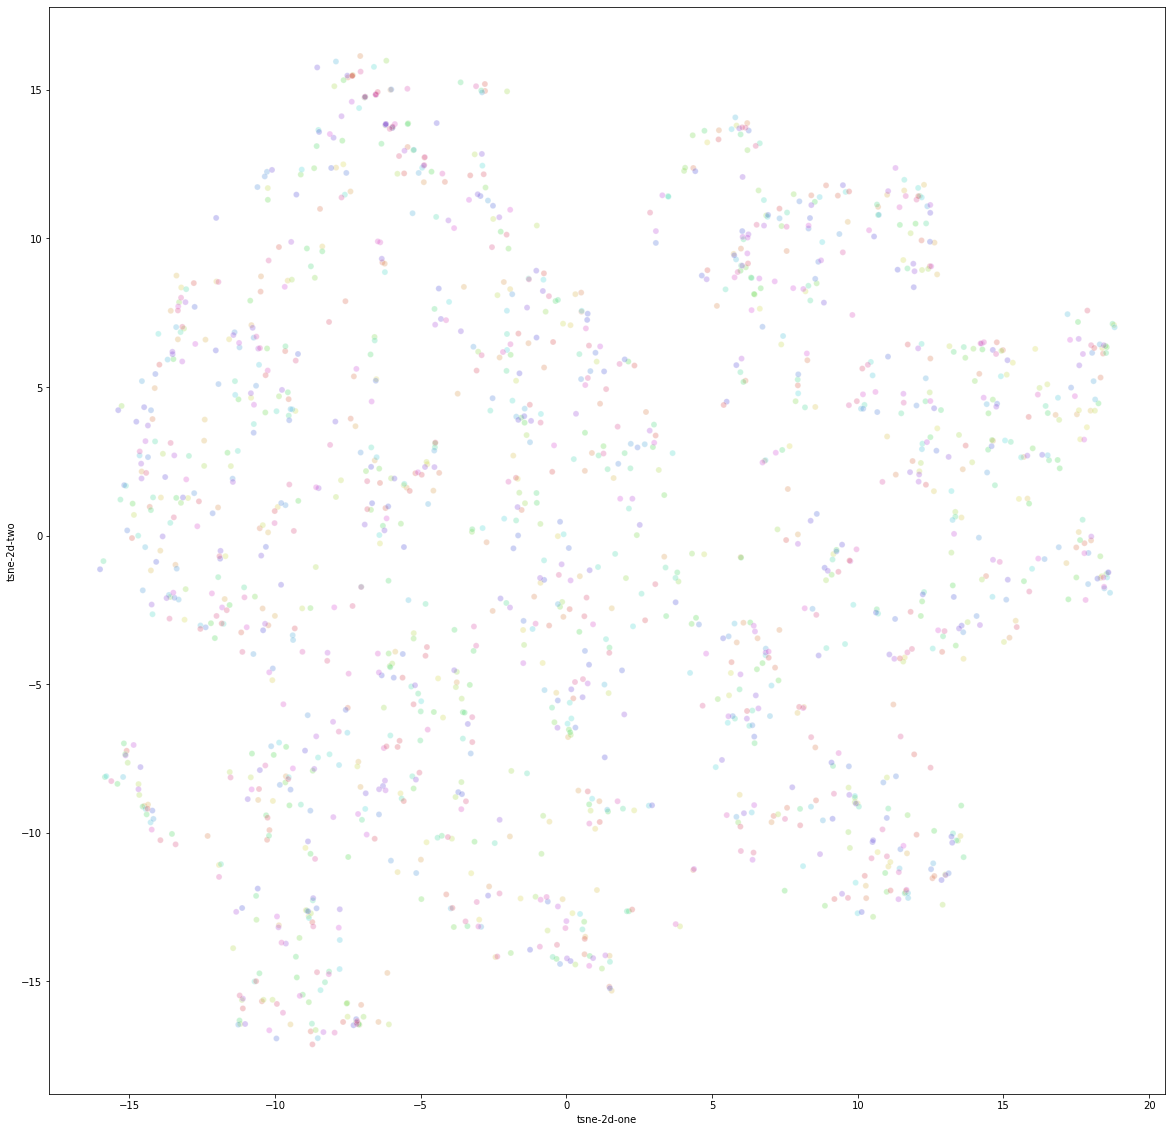

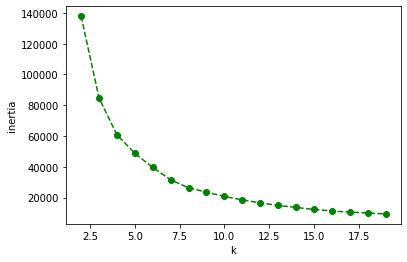

Text(0.5, 0, 'tsne-2d-one')

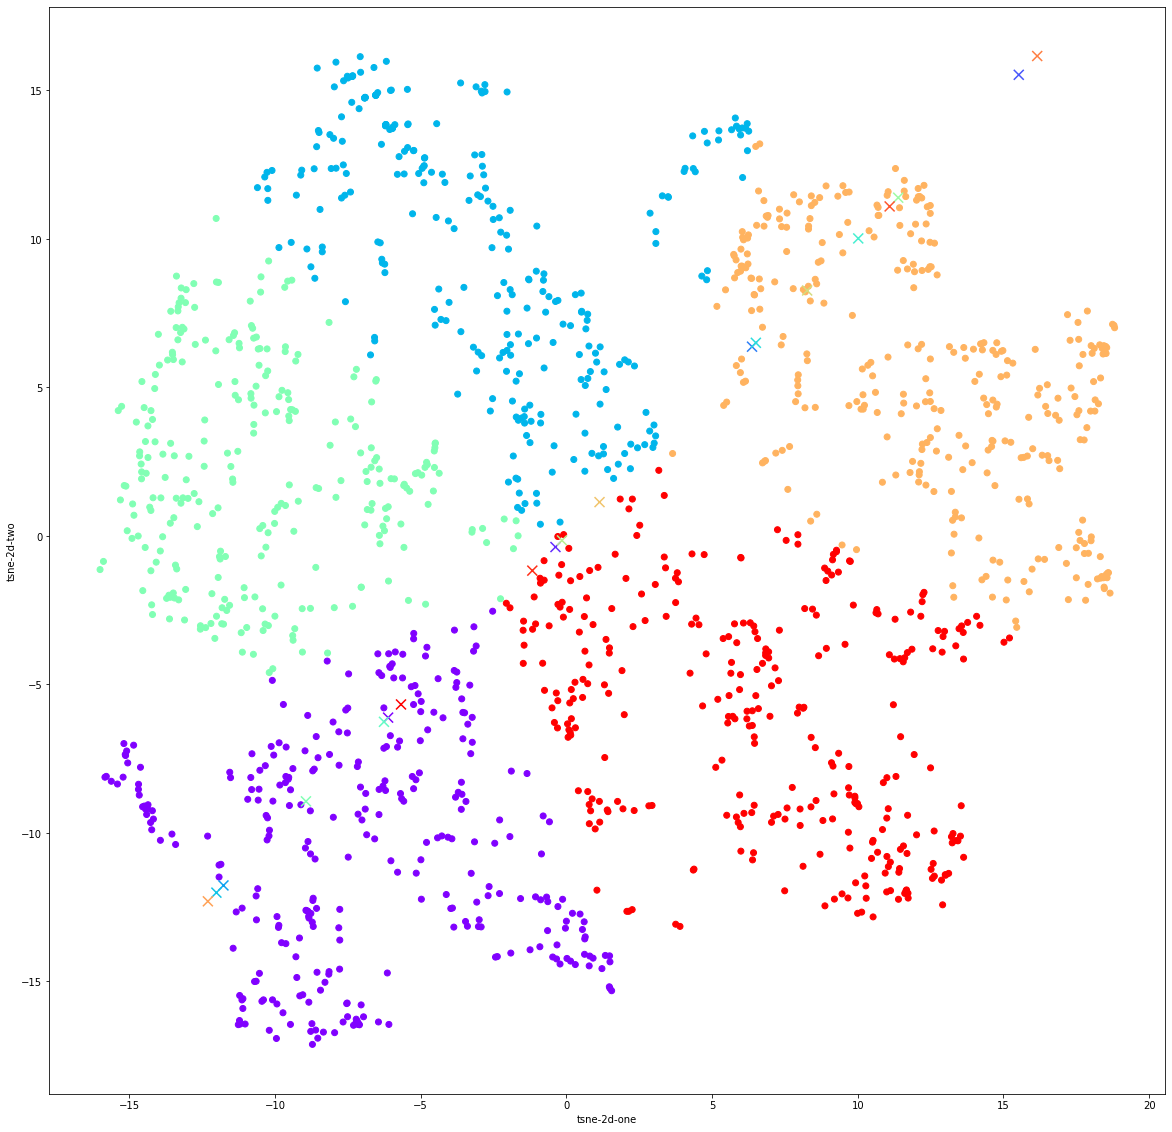

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    problem1_df.head()
    #xy = problem1_df.drop(['VidID','s', 's_avg', 's_rel_avg', 's_tot_avg'], axis = 1)
    xy = problem1_df.drop(['VidID', 's', 's_rel_avg', 's_tot_avg'], axis = 1)
    return xy

dft, dfs = readdata("behavior-performance.txt")

df = filter(dfs)#dfs.copy()
for col in df.columns[2:]:
    df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
columns = df.columns[2:]
print(columns)
print(df.head)


# rndperm = np.random.permutation(df.shape[0])
# df_subset = df.loc[rndperm,:].copy()

#model = PCA(n_components=2)#keep all components 
model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
data = model.fit_transform(df[columns].values)

df['tsne-2d-one'] = data[:,0]
df['tsne-2d-two'] = data[:,1]
fig = plt.figure(figsize = (20, 20))

sns.scatterplot(x = "tsne-2d-one", y = "tsne-2d-two", hue = "userID", palette=sns.color_palette("hls", data.shape[0]), data = df, alpha = 0.3, legend = False)
plt.show()

max_ks = 20
inertias = []
models = []
for k in range(2, max_ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    models.append(kmeans)


elbow = 4
kmeans = models[elbow - 1]
plt.plot(np.array(list(range(2, max_ks))), np.array(inertias), 'go--')
plt.ylabel("inertia")
plt.xlabel("k")
plt.show()

figure2 = plt.figure(figsize=(20, 20))
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_, cmap='rainbow')
plt.scatter(centers[:,0], centers[:,0], c=np.arange(centers.shape[0]), marker='x', s=100, cmap='rainbow')
plt.ylabel("tsne-2d-two")
plt.xlabel("tsne-2d-one")

total data points: 29304, total unique students: 3976

Index(['fracSpent', 'fracComp', 'fracPlayed', 'fracPaused', 'numPauses',
       'avgPBR', 'stdPBR', 'numRWs', 'numFFs', 's'],
      dtype='object')
<bound method NDFrame.head of                                          userID  VidID  ...    numFFs         s
16613  0002a8040dd93a3b460539c4eaa0e78750da40dd     13  ... -0.246095  0.712434
17126  0002a8040dd93a3b460539c4eaa0e78750da40dd     14  ... -0.246095 -1.403638
4482   0002a8040dd93a3b460539c4eaa0e78750da40dd      1  ... -0.246095  0.712434
13106  0002a8040dd93a3b460539c4eaa0e78750da40dd      8  ... -0.246095  0.712434
9298   0002a8040dd93a3b460539c4eaa0e78750da40dd      5  ... -0.089107  0.712434
...                                         ...    ...  ...       ...       ...
16902  ffd8ce5026fd727ea62873d2614229539f0d2270     14  ... -0.089107  0.712434
13526  ffd8ce5026fd727ea62873d2614229539f0d2270      9  ... -0.246095 -1.403638
24990  ffd8ce5026fd727ea62873d2614229539f0d2270

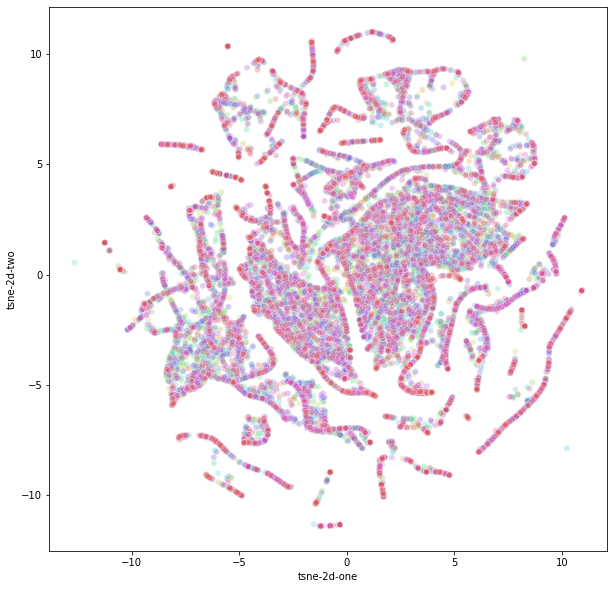

5


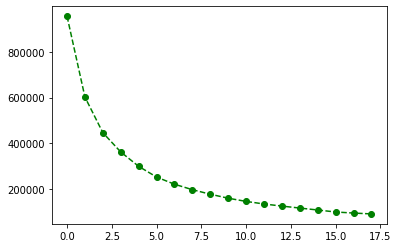

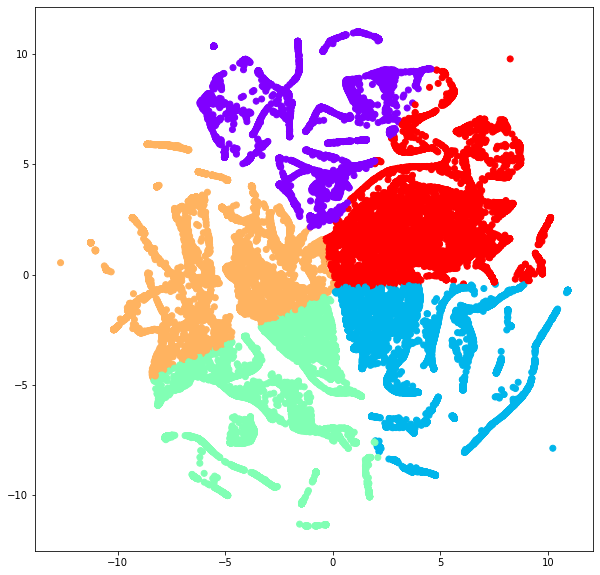

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    problem1_df.head()
    #xy = problem1_df.drop(['VidID','s', 's_avg', 's_rel_avg', 's_tot_avg'], axis = 1)
    xy = problem1_df.drop(['VidID', 's', 's_rel_avg', 's_tot_avg'], axis = 1)
    return xy

dft, dfs = readdata("behavior-performance.txt")

nums = list(dfs["userID"])
nums = len(nums)
df = dft
#df = filter(dft)#dfs.copy()
for col in df.columns[2:]:
    df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
columns = df.columns[2:]
print(columns)
print(df.head)


# rndperm = np.random.permutation(df.shape[0])
# df_subset = df.loc[rndperm,:].copy()

#model = PCA(n_components=2)#keep all components 
model = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
data = model.fit_transform(df[columns].values)

df['tsne-2d-one'] = data[:,0]
df['tsne-2d-two'] = data[:,1]
fig = plt.figure(figsize = (10, 10))

sns.scatterplot(x = "tsne-2d-one", y = "tsne-2d-two", hue = "userID", palette=sns.color_palette("hls", nums), data = df, alpha = 0.3, legend = False)
plt.show()

max_ks = 20
inertias = []
models = []
ks = []
for k in range(2, max_ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    models.append(kmeans)
    ks.append(k)

elbow = 4
kmeans = models[elbow - 1]
print(ks[elbow - 1])
plt.plot(np.array(inertias), 'go--')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.scatter(data[:,0], data[:,1], c=kmeans.labels_, cmap='rainbow')
axe.scatter(centers[:,0], centers[:,0], c=np.arange(centers.shape[0]), marker='x', s=100, cmap='rainbow')

total data points: 29304, total unique students: 3976

Index(['fracComp', 'fracPlayed', 'fracPaused', 'numPauses', 'avgPBR', 'stdPBR',
       'numRWs', 'numFFs', 'vidsWatched', 's_avg'],
      dtype='object')
<bound method NDFrame.head of                                         userID  ...     s_avg
0     0002a8040dd93a3b460539c4eaa0e78750da40dd  ...  0.288444
5     003942fd8e86b59e8d63bf98a06bca2b09e5c665  ... -0.235948
12    00b098ff9568683910095337baa28accffce9e15  ...  0.550641
19    014e4b949c41b94138b133c6cc8f866a452153b2  ... -0.235948
20    014ff11944ac2e574a2c037a826f33b58136ca86  ... -0.760341
...                                        ...  ...       ...
3964  ff5753ad198970894db6782fad93531ba3527158  ... -0.410746
3966  ff6214fdd9a97efab26df04d589b25840ed0f85e  ... -0.585543
3971  ffc056bac4bd97fb466f6a055d56ad10c92edbc3  ... -0.323347
3972  ffc6e495a3497ee2cfad660cb22e3364f708ed42  ... -0.498144
3973  ffd8ce5026fd727ea62873d2614229539f0d2270  ...  2.298616

[1535 rows x 12 

<Figure size 1440x1440 with 0 Axes>

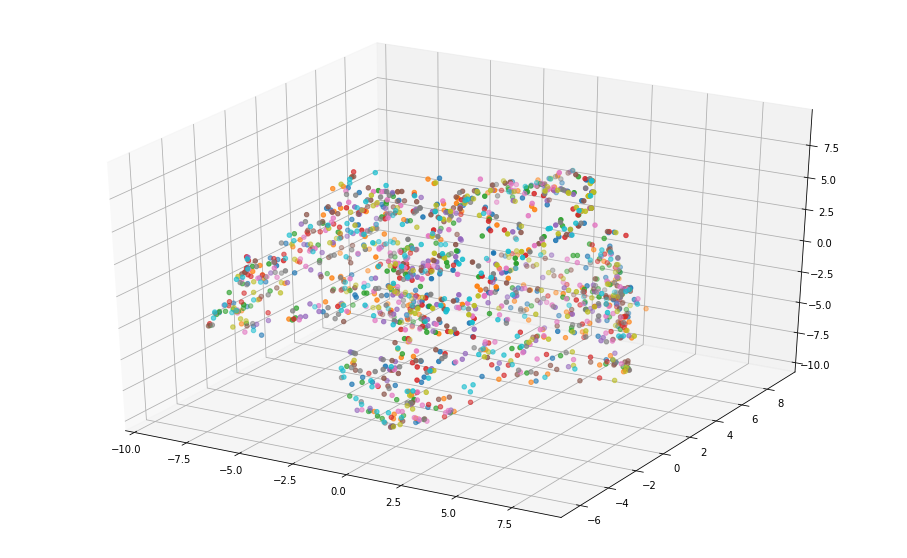

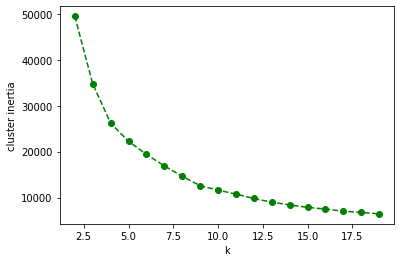

(1535,)


<Figure size 1440x1440 with 0 Axes>

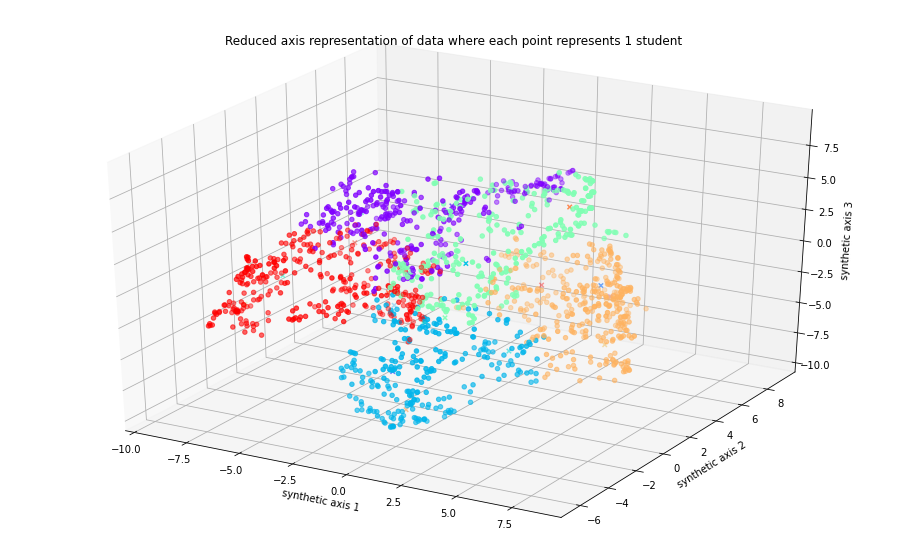

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    problem1_df.head()
    #xy = problem1_df.drop(['VidID','s', 's_avg', 's_rel_avg', 's_tot_avg'], axis = 1)
    xy = problem1_df.drop(['VidID', 's', 's_rel_avg', 's_tot_avg'], axis = 1)
    return xy

dft, dfs = readdata("behavior-performance.txt")

df = filter(dfs)#dfs.copy()
for col in df.columns[2:]:
    df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
columns = df.columns[2:]
print(columns)
print(df.head)

model = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
data = model.fit_transform(df[columns].values)

df['tsne-2d-one'] = data[:,0]
df['tsne-2d-two'] = data[:,1]
df['tsne-2d-three'] = data[:,2]
fig = plt.figure(figsize = (20, 20))

colr = np.linspace(0, df["userID"].values.shape[0], num = df["userID"].values.shape[0])
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs=df["tsne-2d-one"], ys=df["tsne-2d-two"], zs=df["tsne-2d-three"], c=colr, cmap='tab10')
plt.show()

max_ks = 20
inertias = []
models = []
for k in range(2, max_ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    models.append(kmeans)


elbow = 4
kmeans = models[elbow - 1]
plt.plot(np.array(list(range(2, max_ks))), np.array(inertias), 'go--')
plt.xlabel("k")
plt.ylabel("cluster inertia")
plt.show()

figure2 = plt.figure(figsize=(20, 20))
print(df["tsne-2d-one"].shape)
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(xs=df["tsne-2d-one"], ys=df["tsne-2d-two"], zs=df["tsne-2d-three"], c=kmeans.labels_, cmap='rainbow')
ax.scatter(xs=centers[:,0], ys=centers[:,1], zs=centers[:,2], c=np.arange(centers.shape[0]), marker='x',cmap='rainbow')
ax.set_xlabel('synthetic axis 1')
ax.set_ylabel('synthetic axis 2')
ax.set_zlabel('synthetic axis 3')
ax.set_title('Reduced axis representation of data where each point represents 1 student')
plt.show()


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    problem1_df.head()
    #xy = problem1_df.drop(['VidID','s', 's_avg', 's_rel_avg', 's_tot_avg'], axis = 1)
    xy = problem1_df.drop(['VidID', 's', 's_rel_avg', 's_tot_avg'], axis = 1)
    return xy

dft, dfs = readdata("behavior-performance.txt")

nums = list(dfs["userID"])
nums = len(nums)
df = dft

for col in df.columns[2:]:
    df[col] = (df[col] - np.mean(df[col]))/np.std(df[col])
columns = df.columns[2:]
print(columns)
print(df.head)


# rndperm = np.random.permutation(df.shape[0])
# df_subset = df.loc[rndperm,:].copy()

#model = PCA(n_components=3)#keep all components 
model = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
data = model.fit_transform(df[columns].values)

df['tsne-2d-one'] = data[:,0]
df['tsne-2d-two'] = data[:,1]
df['tsne-2d-three'] = data[:,2]
fig = plt.figure(figsize = (20, 20))

colr = np.linspace(0, df["userID"].values.shape[0], num = df["userID"].values.shape[0])

ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["tsne-2d-one"], 
    ys=df["tsne-2d-two"], 
    zs=df["tsne-2d-three"], 
    c=colr, 
    cmap='tab10'
)
plt.show()

max_ks = 20
inertias = []
models = []
for k in range(2, max_ks):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    centers = kmeans.cluster_centers_
    inertias.append(kmeans.inertia_)
    models.append(kmeans)


elbow = 4
kmeans = models[elbow - 1]
plt.plot(np.array(inertias), 'go--')
plt.show()

figure2 = plt.figure(figsize=(20, 20))
#plt.scatter(data[:,0], data[:,1], c=kmeans.labels_, cmap='rainbow')
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df["tsne-2d-one"], 
    ys=df["tsne-2d-two"], 
    zs=df["tsne-2d-three"], 
    c=kmeans.labels_, 
    cmap='rainbow'
)
ax.scatter(
    xs=centers[:,0], 
    ys=centers[:,1], 
    zs=centers[:,2], 
    c=np.arange(centers.shape[0]), 
    marker='x',
    cmap='rainbow'
)
plt.show()

#plt.scatter(centers[:,0], centers[:,0], c=np.arange(centers.shape[0]), marker='x', s=100, cmap='rainbow')

total data points: 29304, total unique students: 3976

Index(['fracSpent', 'fracComp', 'fracPlayed', 'fracPaused', 'numPauses',
       'avgPBR', 'stdPBR', 'numRWs', 'numFFs', 's'],
      dtype='object')
<bound method NDFrame.head of                                          userID  VidID  ...    numFFs         s
16613  0002a8040dd93a3b460539c4eaa0e78750da40dd     13  ... -0.246095  0.712434
17126  0002a8040dd93a3b460539c4eaa0e78750da40dd     14  ... -0.246095 -1.403638
4482   0002a8040dd93a3b460539c4eaa0e78750da40dd      1  ... -0.246095  0.712434
13106  0002a8040dd93a3b460539c4eaa0e78750da40dd      8  ... -0.246095  0.712434
9298   0002a8040dd93a3b460539c4eaa0e78750da40dd      5  ... -0.089107  0.712434
...                                         ...    ...  ...       ...       ...
16902  ffd8ce5026fd727ea62873d2614229539f0d2270     14  ... -0.089107  0.712434
13526  ffd8ce5026fd727ea62873d2614229539f0d2270      9  ... -0.246095 -1.403638
24990  ffd8ce5026fd727ea62873d2614229539f0d2270

KeyboardInterrupt: ignored

total data points: 29304, total unique students: 3976

                                      userID  ... s_tot_avg
0   0002a8040dd93a3b460539c4eaa0e78750da40dd  ...  0.150538
5   003942fd8e86b59e8d63bf98a06bca2b09e5c665  ...  0.086022
12  00b098ff9568683910095337baa28accffce9e15  ...  0.182796
19  014e4b949c41b94138b133c6cc8f866a452153b2  ...  0.086022
20  014ff11944ac2e574a2c037a826f33b58136ca86  ...  0.021505

[5 rows x 16 columns]
46


<Figure size 1080x1080 with 0 Axes>

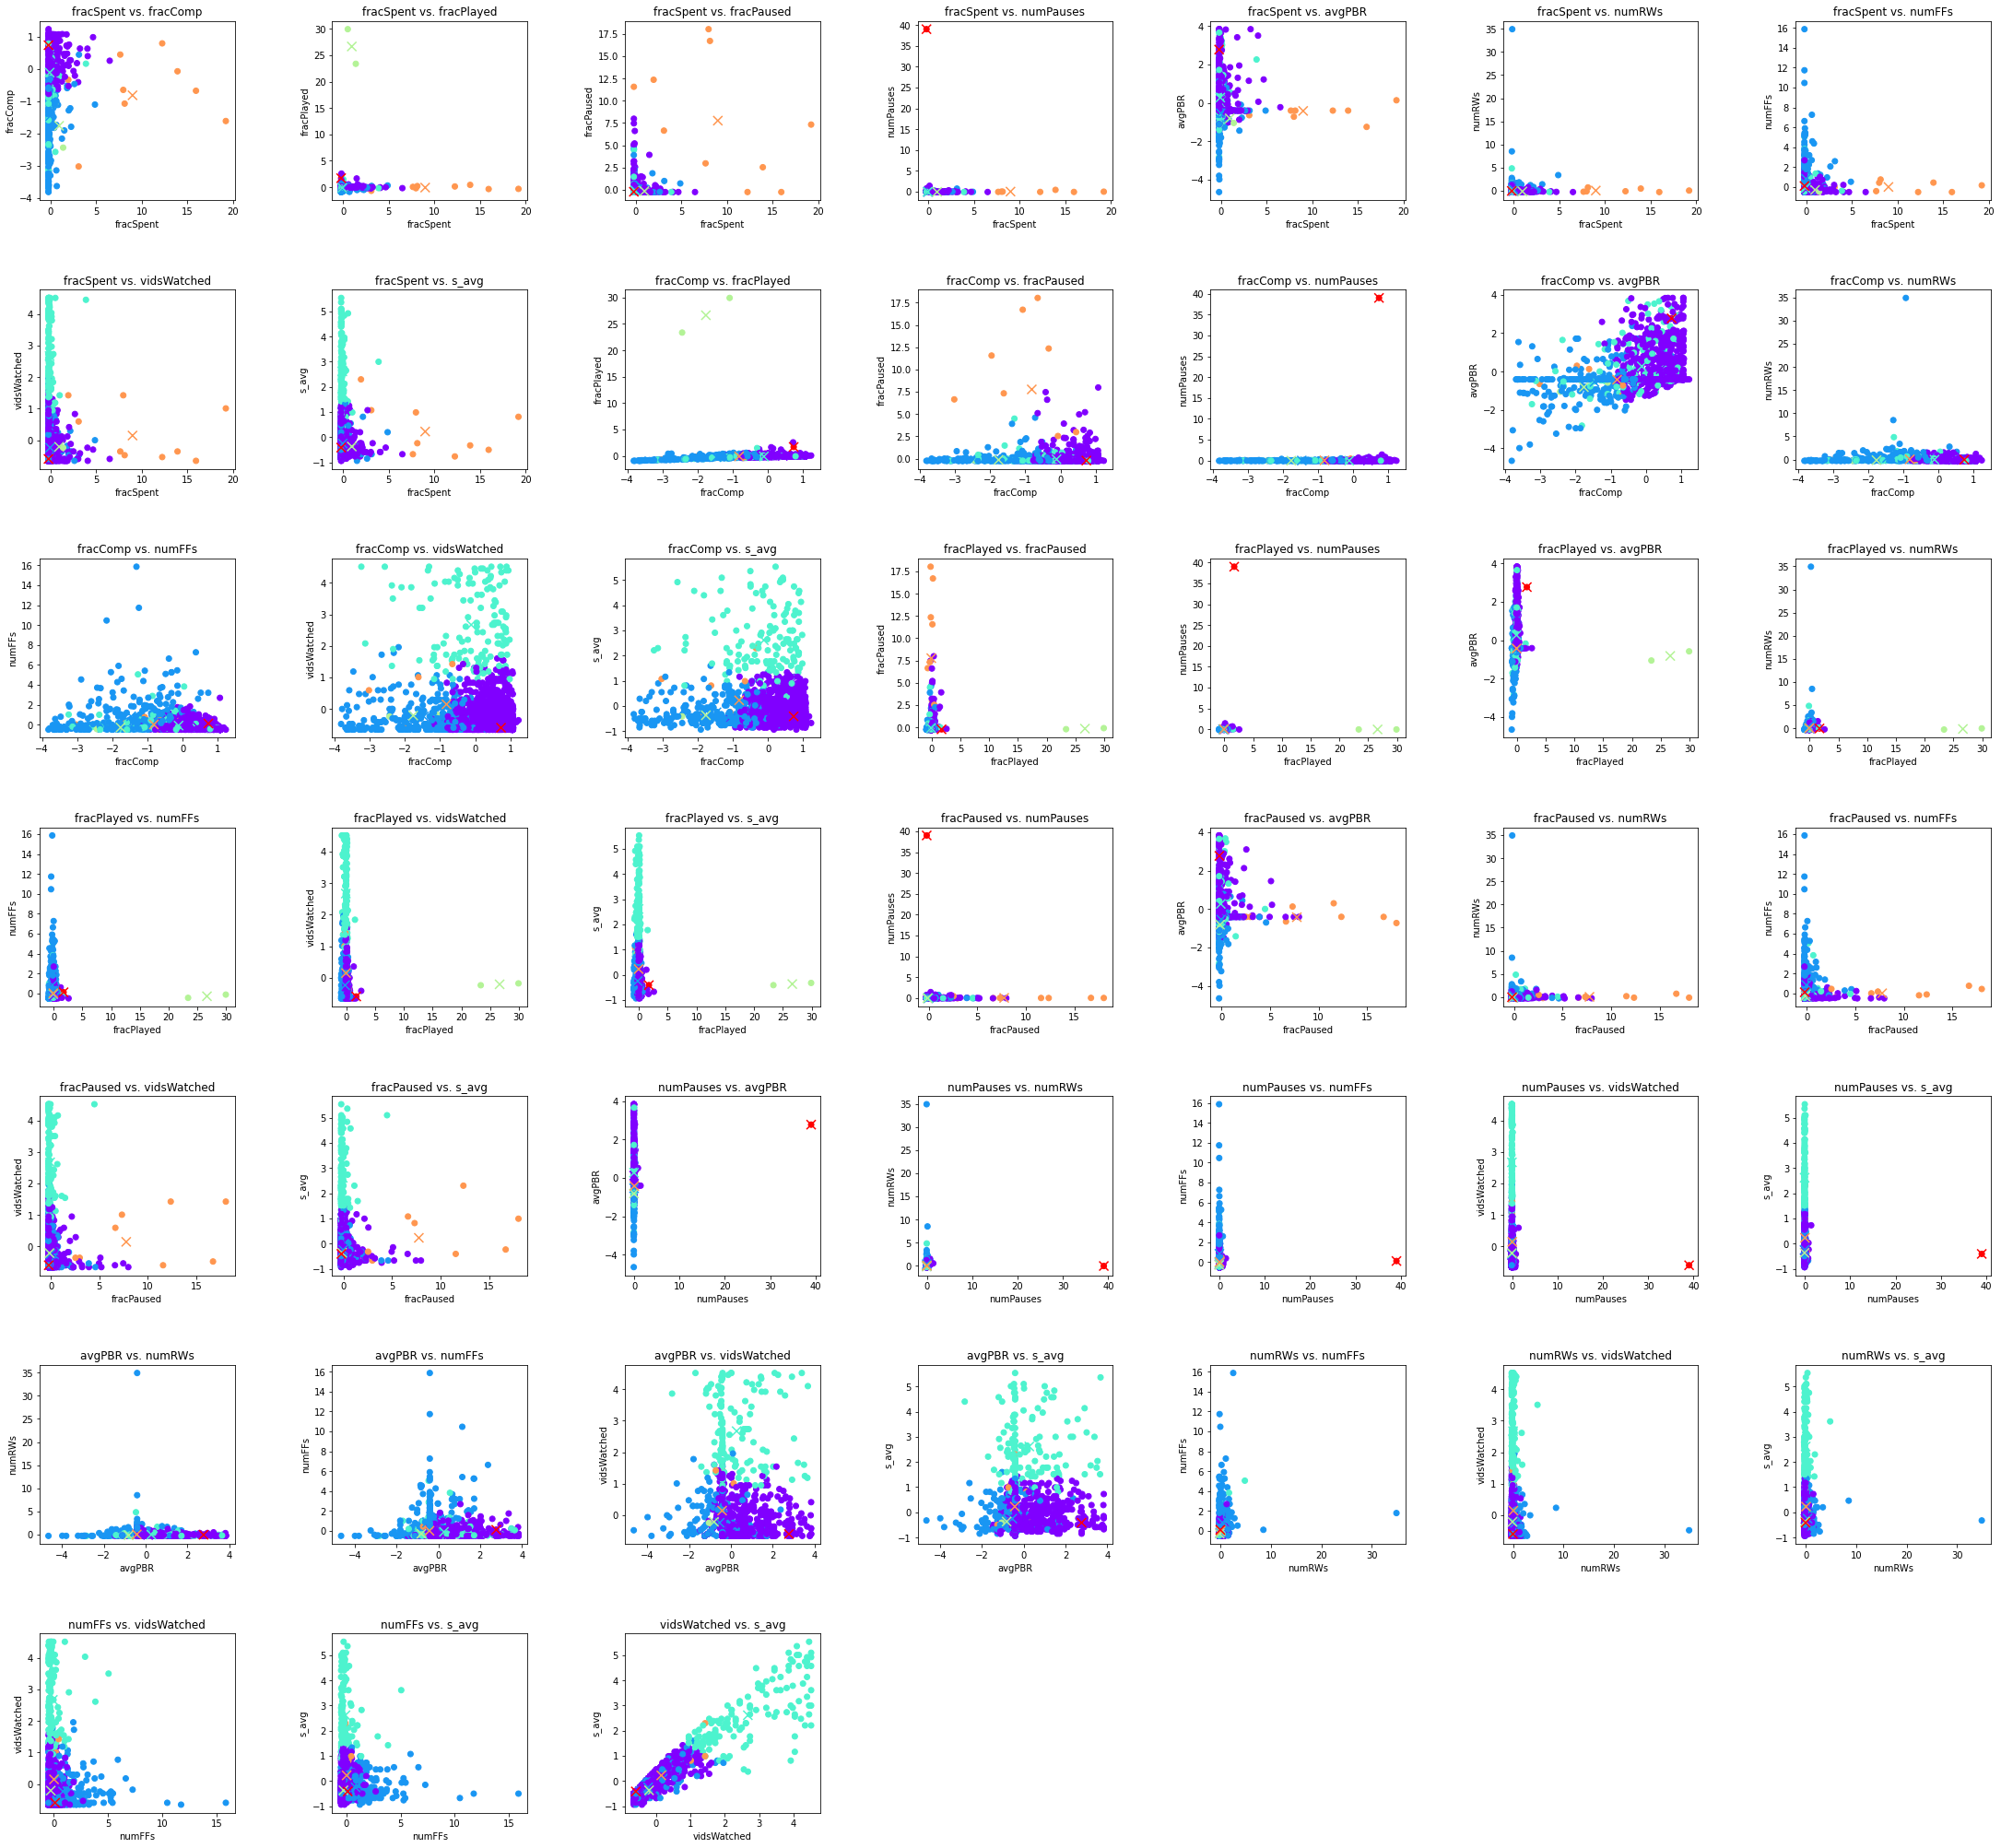

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
#from sklearn.linear_model import LogisticRegression

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    print(problem1_df.head())
    xy = problem1_df.drop(['VidID', 's', 's_rel_avg', 's_tot_avg', 'stdPBR'], axis = 1)
    return xy

dft, dfs = readdata("behavior-performance.txt")
xy = filter(dfs)
figure = plt.figure(figsize=(15,15))

# count = 1
# for col in range(1,7):
#     for two in range (col + 1, 7):
#         gr = xy.columns[col], " vs ", xy.columns[two]
#         t1 = []
#         t2 = []
#         for i in xy[xy.columns[col]]:
#             t1.append(i)
#         for i in xy[xy.columns[two]]:
#             t2.append(i)    
#         X = []
#         for i in range(len(t1)):
#             X.append([t1[i], t2[i]])
#         X = np.array(X)
#         kmeans = KMeans(n_clusters=5) #number of clusters
#         kmeans.fit(X)
#         axe = figure.add_subplot(5, 5, count, title=gr)
#         axe.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')
#         centers = kmeans.cluster_centers_
#         axe.scatter(centers[:,0], centers[:,1], c=np.arange(centers.shape[0]), marker='x', s=100, cmap='rainbow')
#         count += 1
        
xy2 = xy.to_numpy()
xy2, m, s = normalize(xy2[:,1:])
kmeans = KMeans(n_clusters=6) #number of clusters
kmeans.fit(xy2)
centers = kmeans.cluster_centers_
figure2 = plt.figure(figsize=(30, 30))
plt.subplots_adjust(bottom=.05, top=0.95, hspace=.5, wspace=.5, left=.01, right=.99)
count = 1

graph_set = []
for col in range(centers.shape[-1]):
    for two in range(centers.shape[-1]):
        set_used = {xy.columns[col + 1], xy.columns[two + 1]}
        if (two != col and set_used not in graph_set):
            gr = xy.columns[col + 1] + " vs. " + xy.columns[two + 1]
            axe = figure2.add_subplot(7, 7, count, title=gr)
            axe.scatter(xy2[:,col], xy2[:,two], c=kmeans.labels_, cmap='rainbow')
            axe.set_xlabel(xy.columns[col + 1])
            axe.set_ylabel(xy.columns[two + 1])
            axe.scatter(centers[:,col], centers[:,two], c=np.arange(centers.shape[0]), marker='x', s=100, cmap='rainbow')
            count += 1
            graph_set.append(set_used)

print(count)
plt.show()
#figure.tight_layout()
# figure2.tight_layout()

total data points: 29304, total unique students: 3976

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)
[[-6.         -6.         -6.         -6.         -6.         -6.
  -6.         -6.         -6.         -6.        ]
 [-5.99599867 -5.99599867 -5.99599867 -5.99599867 -5.99599867 -5.99599867
  -5.99599867 -5.99599867 -5.99599867 -5.99599867]
 [-5.99199733 -5.99199733 -5.99199733 -5.99199733 -5.99199733 -5.99199733
  -5.99199733 -5.99199733 -5.99199733 -5.99199733]
 [-5.987996   -5.987996   -5.987996   -5.987996   -5.987996   -5.987996
  -5.987996   -5.987996   -5.987996   -5.987996  ]
 [-5.98399466 -5.98399466 -5.98399466 -5.98399466 -5.98399466 -5.98399466
  -5.98399466 -5.98399466 -5.98399466 -5.98399466]]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


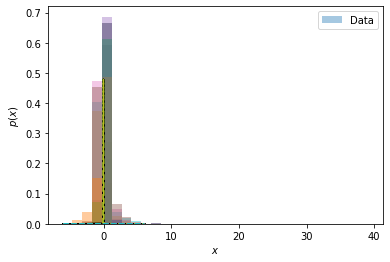

In [0]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
#from sklearn.linear_model import LogisticRegression

def filter(df):
    problem1_df = df["vidsWatched"] >= 5
    problem1_df = df[problem1_df]
    problem1_df.head()
    xy = problem1_df.drop(['VidID','s', 's_avg', 's_rel_avg', 's_tot_avg'], axis = 1)
    return xy

dfs, dft = main()
xy = filter(dfs)
xy2 = xy.to_numpy()
xy2, m, s = normalize(xy2[:,1:])
model = GaussianMixture(n_components=6)
data = model.fit(xy2)
print(data)

def plot_mixture(gmm, X, show_legend=True, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(-6, 6, 3000)
    x = np.expand_dims(x, axis=-1)
    x = np.concatenate([x,x,x,x,x,x,x,x,x,x], axis=-1)
    print(x[:5,:])
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)
    
    responsibilities = gmm.predict_proba(x)
    pdf_individual = responsibilities * pdf[:, np.newaxis]
    ax.hist(X, 30, density=True, histtype='stepfilled', alpha=0.4, label='Data')
    ax.plot(x, pdf, '-k')

    ax.plot(x, pdf_individual, '--')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(x)$')
    if show_legend:
        ax.legend()
plot_mixture(data, xy2)

total data points: 29304, total unique students: 3976

(96, 11)
[1.4113347581314366 -1.2641310252940718 0.3019952869550063
 -0.8073441842214241 1.4113347581314366 0.23674002394462806
 -0.546323132179911 0.7587821280276541 1.2808242321106802
 1.3460794951210584 -0.546323132179911 0.8240373910380324
 -0.8725994472318023 1.215568969100302 -0.6768336582006675
 -1.1988757622836936 -0.8725994472318023 -0.6115783951902893
 -1.5251520773355849 1.2808242321106802 1.1503137060899236
 -1.4598968143252067 -1.32938628830445 -1.1988757622836936
 -1.590407340345963 0.8892926540484106 1.3460794951210584
 0.8240373910380324 1.2808242321106802 -1.2641310252940718
 1.4113347581314366 -1.2641310252940718 -0.28530208013839803
 -1.0031099732525588 0.6282716020068976 0.9545479170587888
 -0.6768336582006675 -0.7420889212110459 0.6282716020068976
 1.4113347581314366 0.23674002394462806 -0.546323132179911
 -0.024281028096884975 0.8892926540484106 -1.0031099732525588
 0.8892926540484106 -0.7420889212110459 0.889

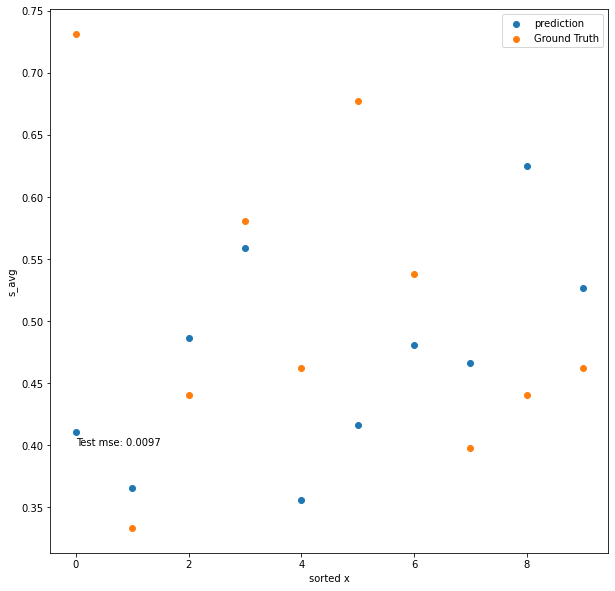

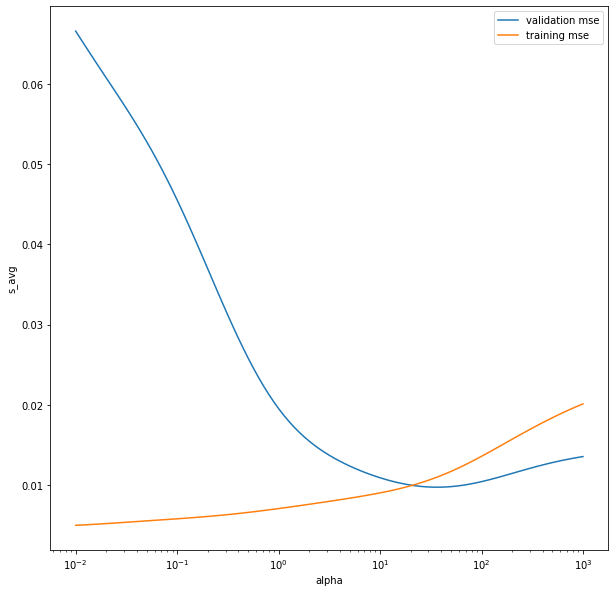

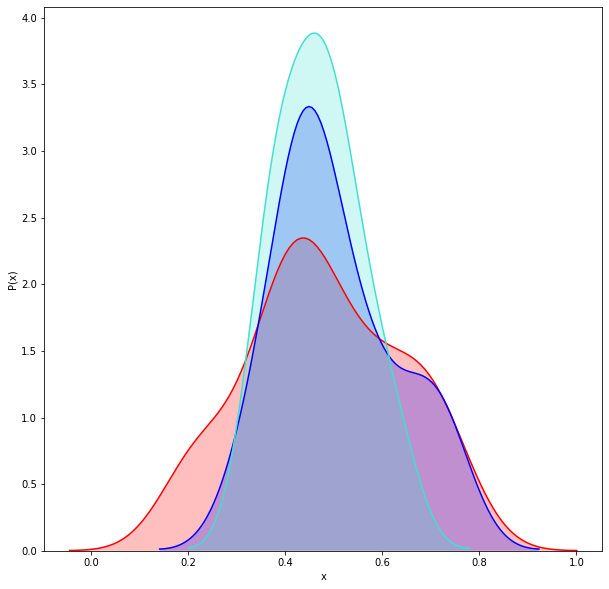

In [59]:
#problem 2 trial 1 linear ridge 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

def filter(df):
    problem2_df = df["vidsWatched"] >= 93//2
    problem2_df = df[problem2_df]
    problem2_df.head()
    xy = problem2_df.drop(['VidID','s', 's_avg', 's_rel_avg', 'stdPBR'], axis = 1)
    print(xy.shape)
    return xy

def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)

    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

dft, dfs = readdata("behavior-performance.txt")
xy = filter(dfs)
x_yarr = xy.to_numpy()
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
print(train_mean)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

degree = 2
alpha = np.logspace(start = -2, stop = 3, base = 10, num = 101)

models = []
mset = []
msev = []

for limit in alpha:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(limit))
    model.fit(X = x_train, y = y_train)
    y_trpred = model.predict(x_train)
    y_pred = model.predict(x_test)
    mset.append(mse(y_train, y_trpred))
    msev.append(mse(y_test, y_pred))
    models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nminimum mse: {np.min(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:,1:-1])
fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[0] - 1, num = y_line.shape[0])
print(ind.shape, y_line.shape, y_test.shape)
plt.scatter(ind, y_line, label = "prediction")
plt.scatter(ind, y_test, label = "Ground Truth")
plt.text(0.00, 0.4, 'Test mse: %.4f' % np.min(np.array(msev)))
plt.xlabel("sorted x")
plt.ylabel("s_avg")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
plt.semilogx(np.array(alpha), np.array(msev), label = "validation mse")
plt.semilogx(np.array(alpha), np.array(mset), label = "training mse")
plt.xlabel("alpha")
plt.ylabel("s_avg")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(y_train, shade = True, color = 'red', legend=True)
sns.kdeplot(y_test, shade = True, color = 'blue', legend=True)
sns.kdeplot(y_line, shade = True, color = 'turquoise', legend=True)
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304, total unique students: 3976

(1535, 11)
[-0.30371288942993924 -0.5432146740424995 -0.0043356586642389556 ...
 0.5345433567140215 -0.6629655663487796 -0.42346378173621935]
(1381, 9)
(1381,)
(154, 9)
(154,)
tf.Tensor([0.10752688 0.02150538 0.11827957 0.09677419 0.03225806], shape=(5,), dtype=float64)
Train on 1381 samples, validate on 154 samples
1381/1381 [==============================] - 3s 2ms/sample - loss: 0.0036 - val_loss: 0.0015
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_114 (Dense)            (None, 9)                 90        
_________________________________________________________________
dense_115 (Dense)            (None, 16)                160       
_________________________________________________________________
dense_116 (Dense)            (None, 16)                272       
_________________________________________________

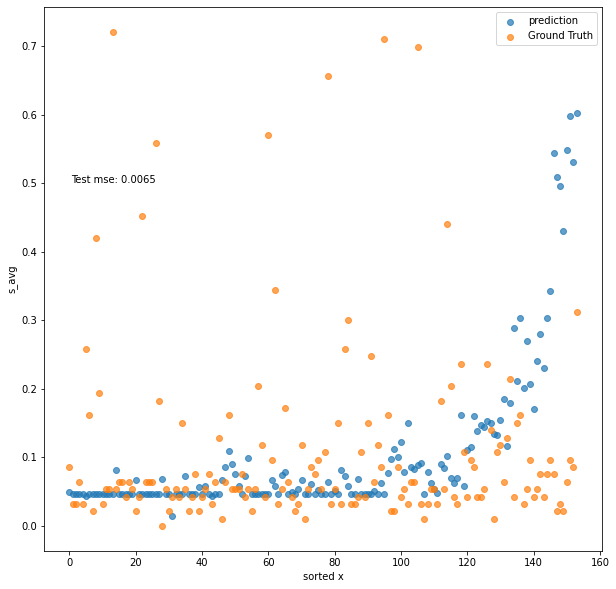

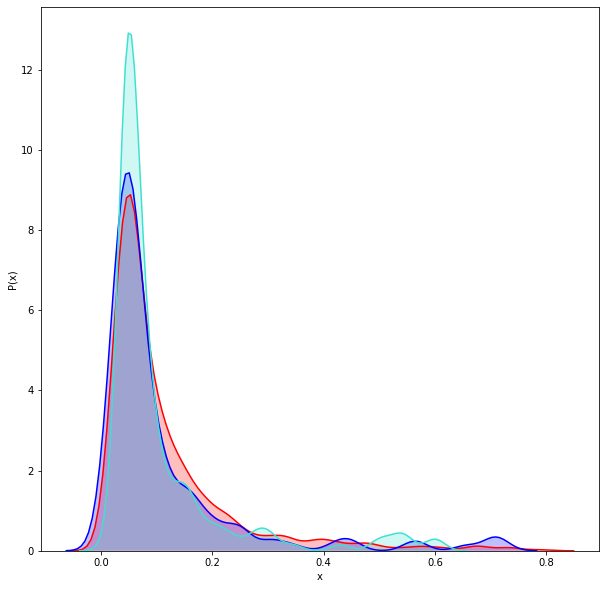

In [45]:
import tensorflow as tf 
import tensorflow.keras as keras

def filter(df):
    problem2_df = df["vidsWatched"] >= 5
    problem2_df = df[problem2_df]
    problem2_df.head()
    xy = problem2_df.drop(['VidID','s', 's_avg', 's_rel_avg', 'stdPBR'], axis = 1)
    print(xy.shape)
    return xy.to_numpy()

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)

    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t


def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

def one_hot_encode(arr):
    a = []
    for value in arr:
        if value == 0:
            a.append(1)
        else:
            a.append(0)
    a = np.array(a)
    arr = np.expand_dims(arr, axis = 1)
    a = np.expand_dims(a, axis = 1)
    arr = np.concatenate([arr, a], axis = -1)
    return np.array(arr)

dft, dfs = readdata("behavior-performance.txt")
x_yarr = filter(dfs)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)

x_train = tf.convert_to_tensor(x_train, dtype = tf.float64)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype = tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype = tf.float64)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 1
models = []
mset = []
msev = []

model = keras.Sequential([
    keras.layers.Dense(x_train.shape[-1], input_shape = (x_train.shape[-1],)),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(16, activation = 'relu'),
    keras.layers.Dense(8, activation = 'relu'),
    keras.layers.Dense(4, activation = 'relu'),
    keras.layers.Dense(1, activation = 'linear'),
])

loss = 'mse'
model.compile(optimizer = keras.optimizers.Adam(), loss = loss)
model.fit(x = x_train, y = y_train, epochs = 1, verbose = 1, validation_data = (x_test, y_test), batch_size = 2)
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)
print(model.summary())

fig = plt.figure(figsize = (10,10))
l = test_full[np.argsort(test_full[:, -1]), :]
l2 = tf.convert_to_tensor(l[:, 1:-1], dtype = tf.float64)
y_line = model.predict(l2)
y_line = np.array(y_line)
ind = np.linspace(0, y_line.shape[0] - 1, num = y_line.shape[0])
plt.scatter(ind, y_line, label = "prediction", alpha = 0.7)
plt.scatter(ind, y_test, label = "Ground Truth", alpha = 0.7)
plt.text(0.5, 0.5, 'Test mse: %.4f' %0.0065)
plt.xlabel("sorted x")
plt.ylabel("s_avg")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
y_train = np.array(y_train)
y_test = np.array(y_test)
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line[:, 0]), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

                                     userID  VidID  ...  cumulative_avg  s
0  ff61169c30cf55070593322a09d29f77ef3653da     31  ...        0.000000  0
1  527c7585c71cfb2b6187fc011c270f1de1b4baee      3  ...        0.000000  1
2  527c7585c71cfb2b6187fc011c270f1de1b4baee      4  ...        1.000000  0
3  527c7585c71cfb2b6187fc011c270f1de1b4baee      5  ...        0.500000  1
4  527c7585c71cfb2b6187fc011c270f1de1b4baee      6  ...        0.666667  1

[5 rows x 16 columns]
ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[0.6047035609790993 -1.740650732818886 0.3766830046376284 ...
 -1.740650732818886 -1.740650732818886 -1.740650732818886]
(17758, 12)
(17758,)
(1974, 12)
(1974,)
[0 1 0 1 0]

minimum mse: 0.49860903902144305


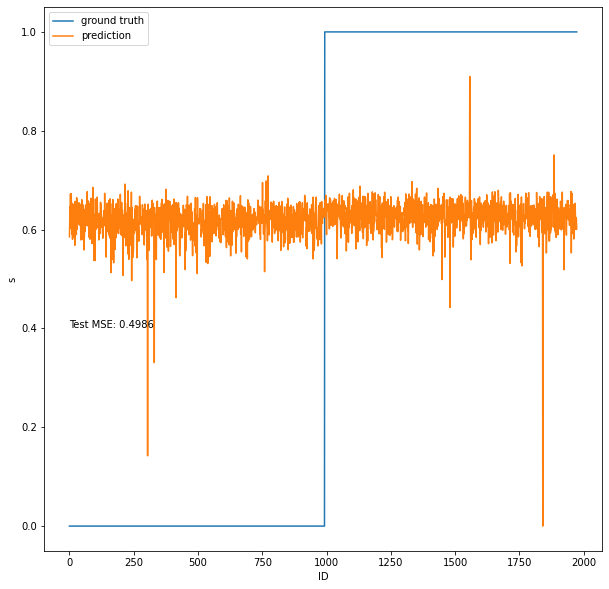

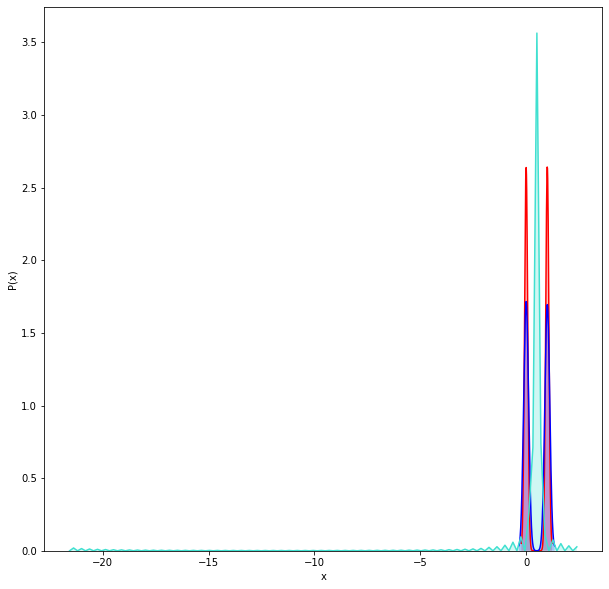

In [6]:
#problem 3 trial 1 linear ridge, not accurate -> all points learned = 0.5
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import mode
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge

def filter(df):
    df = df.sort_values("s")
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)

    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

def sigmoid(t):
    return (1/(1 + np.exp(-t)))

#dfs, dft = main()
#dft = readdata2("idontwanttoprocessyouagain.csv")
dft = readdata2("helpme.csv")
print(dft.head(5))
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 3
alpha = np.logspace(start = -1, stop = 2, base = 10, num = 101)
models = []
mset = []
msev = []

for limit in alpha:
    model = make_pipeline(PolynomialFeatures(degree), Ridge(limit))
    model.fit(X = x_train, y = y_train)
    y_trpred = model.predict(x_train)
    y_pred = model.predict(x_test)
    mset.append(mse(y_train, y_trpred))
    msev.append(mse(y_test, y_pred))
    models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nminimum mse: {np.min(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.4, 'Test MSE: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth")
plt.plot(ind, sigmoid(y_line), label = "prediction")
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['af39d0e21b76125b4593819bd52439bbef0392f6' 1.0184318555 0.995415848856
  ... 2 0.5 0]
 ['eac5fc6ea7f3a3f4e865e3471ed8e04741395236' 0.997462603878
  0.995520932523 ... 0 0.0 1]
 ['460246e1b4d79a6debaf3fa28c7916ba09856993' 0.950733333333
  0.958973954814 ... 5 0.8333333333333334 0]
 ...
 ['8124aded672d2c6e2869bb5d1c5f107fa38a39e4' 0.570566552901
  0.991246194156 ... 17 0.7391304347826086 0]
 ['e6271afa9bda71d3435e19118a1167389350a039' 0.996770083102
  0.995480580563 ... 0 0.0 0]
 ['c0c63845483d562009f653bbf85550fa033a0af4' 0.93853699284 0.938471948883
  ... 18 0.6923076923076923 0]]
[0.5 0.0 0.8333333333333334 ... 0.0 0.5 0.7692307692307693]
17758
(17758, 12)
(17758,)
(1974, 12)
(1974,)
[0 1 0 0 1]

Maximum Accuracy: 0.5655022103106757


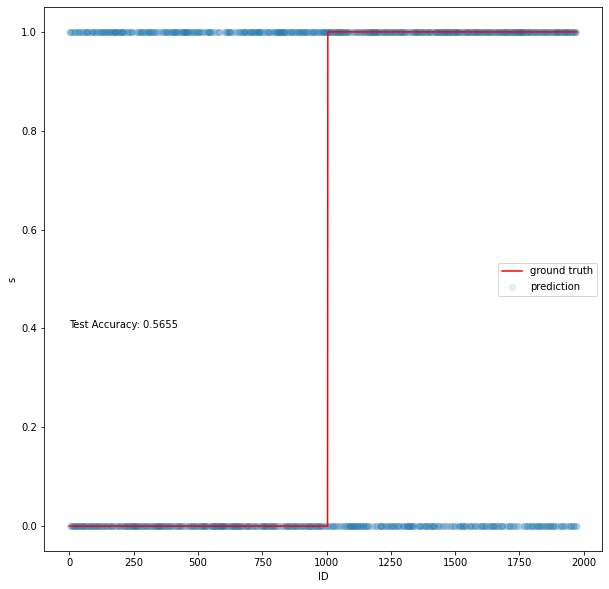

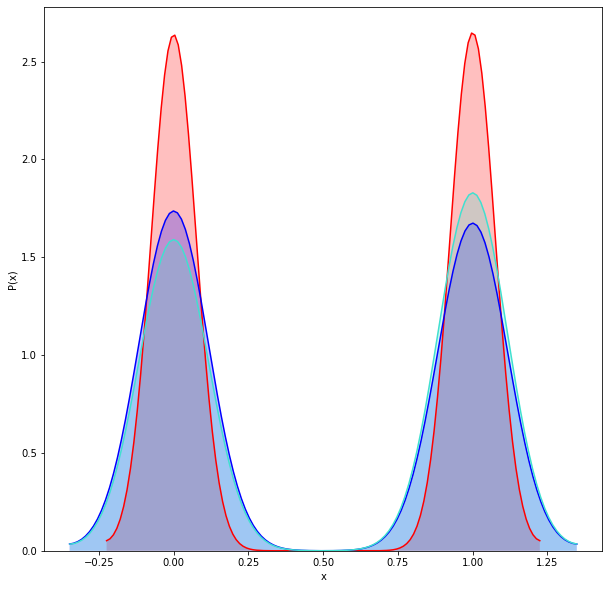

In [12]:
#problem 3 -> basically guessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import mode

def filter(df):
    df = df.sort_values("s")
    #xy = df.drop(['VidID', 'stdPBR', 'cumulative_vids', 'cumulative_s','cumulative_avg'], axis = 1)
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

#dfs, dft = main()
#dft, dfs = readdata("behavior-performance.txt")
dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = False)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 1
models = []
mset = []
msev = []

# for limit in alpha:
model = LogisticRegression(C=1e5, penalty = 'l2', solver = 'lbfgs', max_iter = 1000)
model.fit(X = x_train, y = y_train)
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)
mset.append(roc_auc_score(y_train, y_trpred))
msev.append(roc_auc_score(y_test, y_pred))
models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nMaximum Accuracy: {np.max(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.4, 'Test Accuracy: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth", color = 'red')
plt.scatter(ind, y_line, label = "prediction", alpha=0.1)
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['282c6203bb38c984ea5893b3660fdfc14d84fee0' 0.799211437171
  0.998127061142 ... 0 0.0 0]
 ['458ae7e2edbaa0f1699bd0a1c5bdc4e4e610935e' 1.33265274463 0.866014117403
  ... 1 1.0 1]
 ['1891a61af06bd9bee94e03404ee002e1b99ba8a1' 1.03862721417 0.930147157125
  ... 49 0.8909090909090909 0]
 ...
 ['dab8f0aca97f4043dc26236689446b6e2467d9af' 0.496739057239 0.99275268529
  ... 2 1.0 1]
 ['79aa2e33c8bf09e3f6a57fffb3352495a1ba3a2d' 0.999557239057
  0.992779972577 ... 2 1.0 1]
 ['5efb55ae0e1fe4a4bc7562b496550b22a9c96fe0' 1.01736288089 0.938043414369
  ... 0 0.0 1]]
[-1.7374316100878868 1.1952760265129063 0.8753442843382742 ...
 0.7064914204127741 -0.6900360255876036 0.6087344991927477]
(17758, 12)
(17758,)
(1974, 12)
(1974,)
[0 1 0 0 0]

minimum Accuracy: 0.5815181060641067


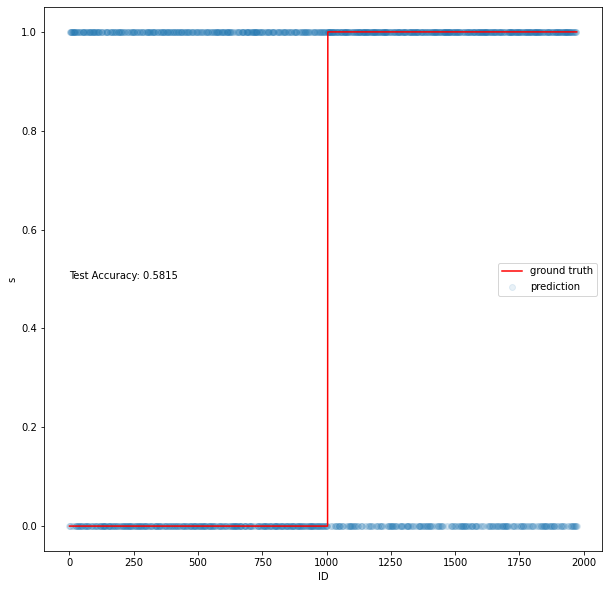

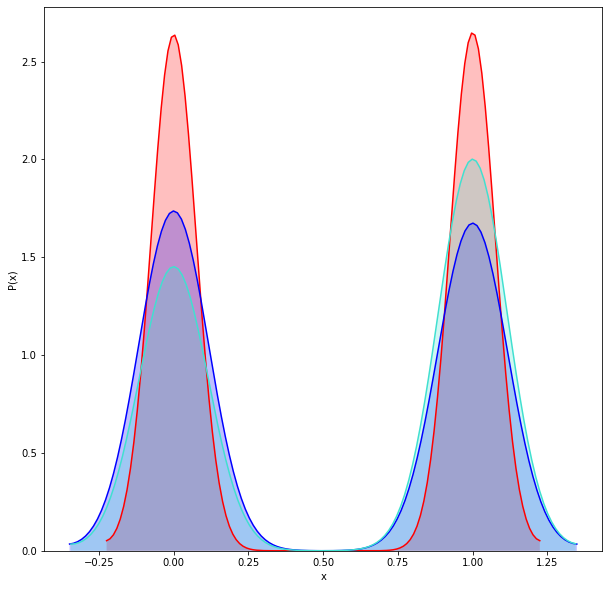

In [14]:
#problem 3 trying an svm
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import mode

def filter(df):
    df = df.sort_values("s")
    #xy = df.drop([ 'fracPlayed', 'stdPBR', 'numRWs', 'cumulative_vids', 'cumulative_s','cumulative_avg', 'shift_s'], axis = 1)
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 1
models = []
mset = []
msev = []

# for limit in alpha:
model = svm.SVC(kernel='linear',gamma='auto')
model.fit(X = x_train, y = y_train)
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)
mset.append(roc_auc_score(y_train, y_trpred))
msev.append(roc_auc_score(y_test, y_pred))
models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nminimum Accuracy: {np.max(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.5, 'Test Accuracy: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth", color = 'red')
plt.scatter(ind, y_line, label = "prediction", alpha=0.1)
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['4f170f77b13963e32218a671de4cf3f12e15ca0b' 0.797336700337
  0.980406173552 ... 2 1.0 1]
 ['148b19d066a92cf1b1b2b70bad07ab55820cf081' 0.995451327434
  0.986817036406 ... 14 0.5384615384615384 0]
 ['df52ec6e38a415b7ca73c2abdc98d28080944063' 1.52065485997 0.583159797078
  ... 4 0.4444444444444444 0]
 ...
 ['b9d22b5a3011fabff2fde404607ebb54a534c446' 1275.62113569
  0.6166993400999999 ... 24 0.8 0]
 ['8b93b4845c1b8844c3eaf197eb306e5947236d02' 0.998836751436
  0.995512038396 ... 0 0.0 0]
 ['a65e2bca74eaba6926aa9ec921e8f613f06f4344' 1.00364201183 0.995597583538
  ... 2 0.6666666666666666 0]]
[1.1923312570651141 -0.1618461324208599 -0.4376970821309657 ...
 -0.27469424821135763 0.4588185044268782 1.1923312570651141]
(17758, 12)
(17758,)
(1974, 12)
(1974,)
[1 0 0 0 1]

minimum Accuracy: 0.509307572835068


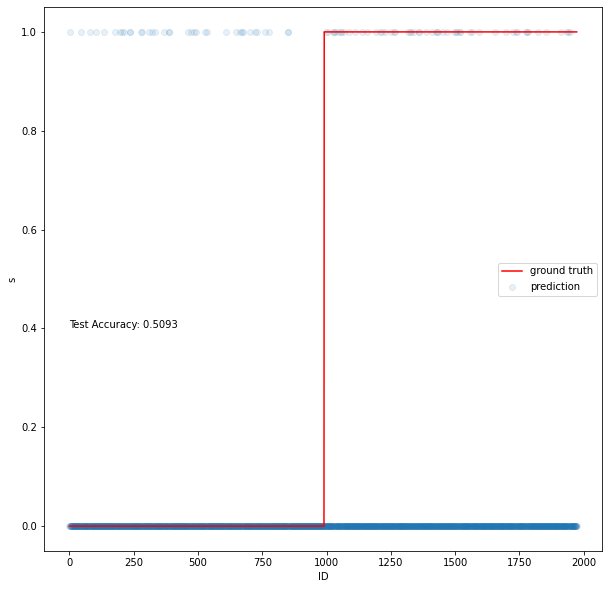

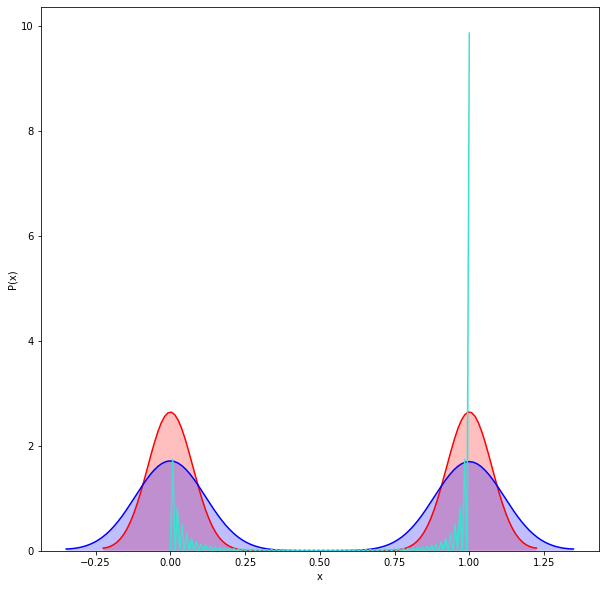

In [17]:
#problem 3 trying Gaussian Bays 
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import roc_auc_score
from scipy.stats import mode

def filter(df):
    df = df.sort_values("s")
    #xy = df.drop([ 'fracPlayed', 'stdPBR', 'numRWs', 'cumulative_vids', 'cumulative_s','cumulative_avg', 'shift_s'], axis = 1)
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 10, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 1
models = []
mset = []
msev = []

# for limit in alpha:
model = GaussianNB()
model.fit(X = x_train, y = y_train)
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)
mset.append(roc_auc_score(y_train, y_trpred))
msev.append(roc_auc_score(y_test, y_pred))
models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nminimum Accuracy: {np.max(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.4, 'Test Accuracy: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth", color = 'red')
plt.scatter(ind, y_line, label = "prediction", alpha=0.1)
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['197aec6ca3bed06f9210482d2dd6c8031ba2801d' 1.01363554007 0.997621202635
  ... 43 0.7288135593220338 1]
 ['7e4a345363d34b9881a5d0138ba7ee2064940925' 0.717822351421
  0.314313025376 ... 11 1.0 0]
 ['a11e3ce647cb27067f4fb5f70838ce2b50abe826' 0.8028221070810001
  0.996042956548 ... 6 1.0 1]
 ...
 ['c7a91afeba88cee450993382f6c59d81ef920054' 0.109848448687
  0.109864563134 ... 14 0.3888888888888889 1]
 ['ca1cc3f31c6f4c28a948b41a9fe4eecaebe150ce' 0.880949382716
  0.994963996793 ... 24 0.7058823529411765 0]
 ['b7649a8efd30353b1e98581c4cbabbc3f787f588' 1.00140436364 0.996451526989
  ... 10 0.9090909090909092 1]]
[0.4094771607449075 1.2056776257475559 1.2056776257475559 ...
 1.2056776257475559 0.7862505950765178 0.30229632891762803]
(17758, 12)
(17758,)
(1974, 12)
(1974,)
[1 0 1 1 1]

minimum Accuracy: 0.5835866261398176


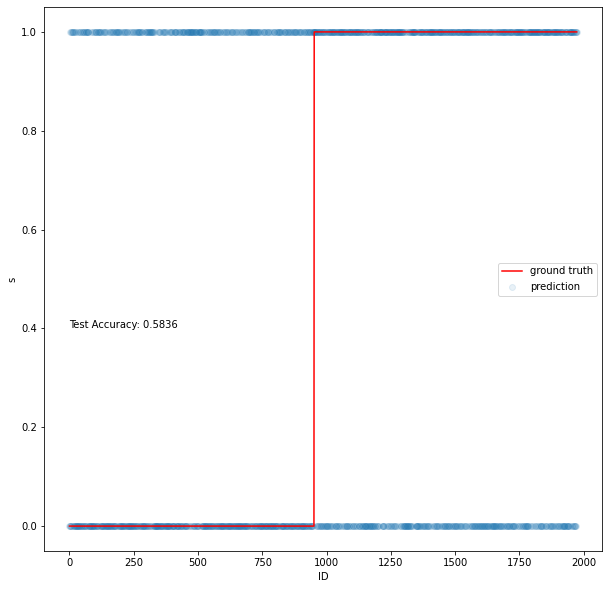

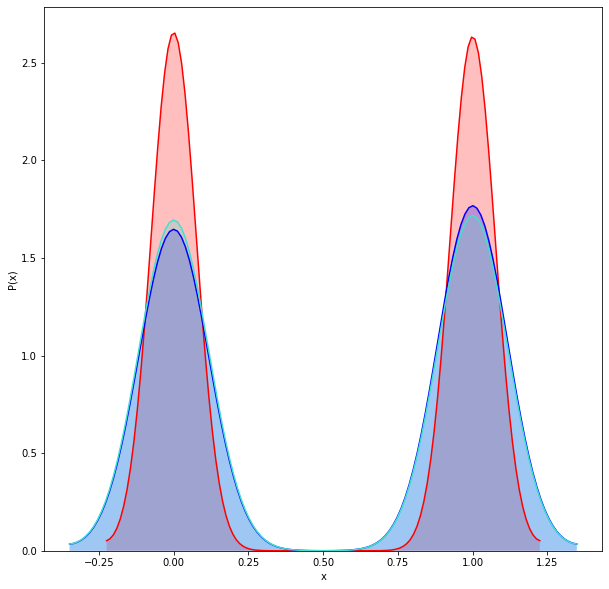

In [21]:
#problem 3 trying Random Forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import mode

def filter(df):
    df = df.sort_values("s")
    #xy = df.drop([ 'fracPlayed', 'stdPBR', 'numRWs', 'cumulative_vids', 'cumulative_s','cumulative_avg', 'shift_s'], axis = 1)
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 10, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
# x_train += abs(np.min(x_train))
# x_test += abs(np.min(x_test))
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

degree = 1
models = []
mset = []
msev = []

# for limit in alpha:
#model = BernoulliNB()
#model = MultinomialNB()
#model = CategoricalNB()
#model = ComplementNB()
model = RandomForestClassifier(n_estimators = 1000)
model.fit(X = x_train, y = y_train)
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)
mset.append(accuracy_score(y_train, y_trpred))
msev.append(accuracy_score(y_test, y_pred))
models.append(model)
    
model = models[np.argmin(np.array(msev))]
print(f"\nminimum Accuracy: {np.max(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.4, 'Test Accuracy: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth", color = 'red')
plt.scatter(ind, y_line, label = "prediction", alpha=0.1)
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

total data points: 29304

ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['9abdc6eebc745bcd2edace49af9efe4ed1f8f0e3' 7 0.99855775076 ... 1.0 0 0]
 ['d0f55b4c7ae3b281253c00faa7b962553101a407' 45 1.0001409395999998 ...
  1.0 0 1]
 ['d9d9c1c18c7bbb124f59740310a3b4bdd74bb191' 15 0.760582210243 ... 1.0 25
  0]
 ...
 ['1a13888326e01f86fc28e3581452305c975a153e' 5 1.13051230629 ... 1.0 0 0]
 ['a3f8ce33728daa1e4f6f9311b4a42d54e14c020e' 9 1.11379901153 ... 1.0 14 0]
 ['3f8bc36490ba7a3bfe8ef8630d81f0f208813e16' 22 0.662920325203 ... 1.5 0
  0]]
[0 0 25 ... 22 0 0]
17758
(17758, 7)
(17758,)
(1974, 7)
(1974,)
0.5014078161955176
0.9931861696136952 0.5440729483282675

minimum Accuracy: 0.5440729483282675


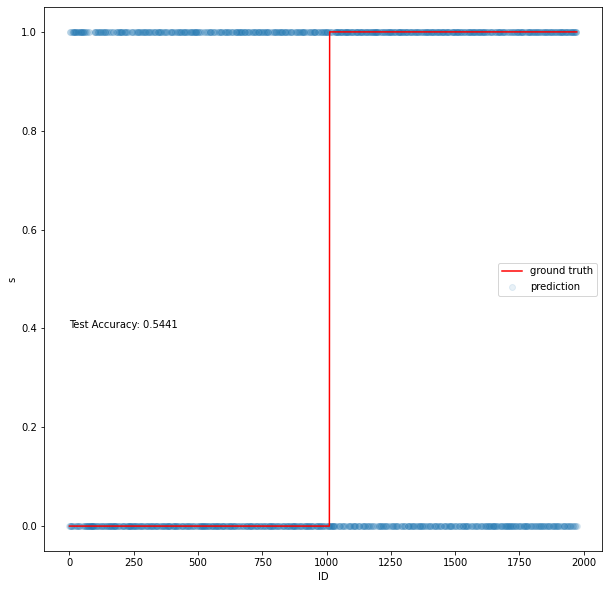

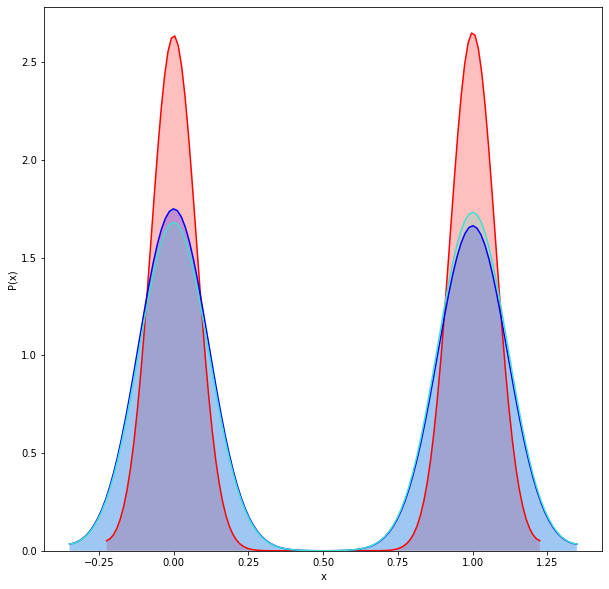

In [23]:
#problem 3 trying Knn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from scipy.stats import mode

def filter(df):
    df = df.sort_values("s")
    xy = df.drop([ 'fracPlayed', 'stdPBR', 'numRWs', 'cumulative_vids', 'cumulative_s','cumulative_avg', 'shift_s'], axis = 1)
    #xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = False)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(np.mean(y_train))


degree = 1
models = []
mset = []
msev = []

# for limit in alpha:
for i in range(1, 3, 2):
    model = KNeighborsClassifier(n_neighbors = i)
    model.fit(X = x_train, y = y_train)
    y_trpred = model.predict(x_train)
    y_pred = model.predict(x_test)
    mset.append(accuracy_score(y_train, y_trpred))
    msev.append(accuracy_score(y_test, y_pred))
    models.append(model)
    print(mset[-1], msev[-1])
    
    
model = models[np.argmax(np.array(msev))]
print(f"\nminimum Accuracy: {np.max(np.array(msev))}")

l = test_full[np.argsort(test_full[:, -1]), :]
y_line = model.predict(l[:, 1:-1])
y_line = np.array(y_line[:])

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.text(0.00, 0.4, 'Test Accuracy: %.4f' % np.min(np.array(msev)))
plt.plot(ind, l[:, -1], label = "ground truth", color = 'red')
plt.scatter(ind, y_line, label = "prediction", alpha=0.1)
plt.xlabel("ID")
plt.ylabel("s")
plt.legend()
plt.show()

fig = plt.figure(figsize = (10,10))
sns.kdeplot(np.array(y_train), shade = True, color = 'red')
sns.kdeplot(np.array(y_test), shade = True, color = 'blue')
sns.kdeplot(np.array(y_line), shade = True, color = 'turquoise')
plt.ylabel("P(x)")
plt.xlabel("x")
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


total data points: 29304, total unique students: 3976

                                         userID  VidID  ...  numFFs  s
16613  0002a8040dd93a3b460539c4eaa0e78750da40dd     13  ...       0  1
17126  0002a8040dd93a3b460539c4eaa0e78750da40dd     14  ...       0  0
4482   0002a8040dd93a3b460539c4eaa0e78750da40dd      1  ...       0  1
13106  0002a8040dd93a3b460539c4eaa0e78750da40dd      8  ...       0  1
9298   0002a8040dd93a3b460539c4eaa0e78750da40dd      5  ...       1  1

[5 rows x 12 columns]
ModeResult(mode=array([0], dtype=object), count=array([9866])) 0.5
[['0ca737c613cebcd2ce06fd4450b3479a3be89d56' 0.9947087542090001
  0.989316612783 ... 0 0 1]
 ['dea4a7038a0bdde2930fba53f208dee34d3698c2' 1.00137080868 0.995670717379
  ... 0 0 1]
 ['e90c42df312d03551a5246ecdc38d9da93383366' 1.14586657682
  0.9935723070829999 ... 0 0 0]
 ...
 ['caf864a1d3cd83863022255f89dda29b74f78aa9' 0.7900078492939999
  0.997828284066 ... 2 0 1]
 ['d7e49f9d942fa13ca609e817b51d21f5fb0ddd9c' 0.9991875 0.99663

No handles with labels found to put in legend.


full (2, 8, 8)


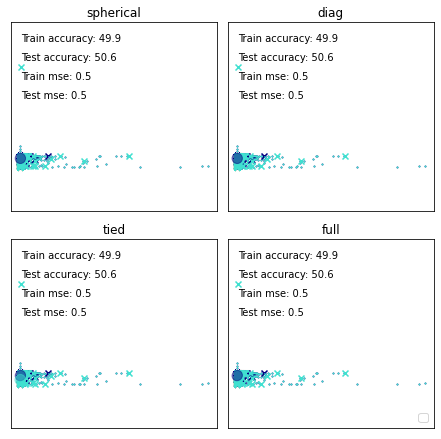

In [24]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn import datasets
from sklearn.model_selection import StratifiedKFold
from sklearn.externals.six.moves import xrange
from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture import BayesianGaussianMixture as bGMM


def filter(df):
    df = df.sort_values("s")
    xy = df.drop(['VidID', 'stdPBR'], axis = 1)
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        print(x_train[:, -1])
        print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, train_data, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

def sigmoid(t):
    return (1/(1 + np.exp(-t)))

colors = ['navy', 'turquoise']#, 'darkorange']
def make_ellipses(gmm, ax, start = 0, stop = 2):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][start:stop, start:stop]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[start:stop, start:stop]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][start:stop])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]

                
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

# iris = datasets.load_iris()

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
# skf = StratifiedKFold(iris.target, n_folds=4)
# Only take the first fold.
# train_index, test_index = next(iter(skf))

#dft = readdata2("idontwanttoprocessyouagain.csv")
dft, dfs = readdata("behavior-performance.txt")
print(dft.head(5))
x_yarr = filter(dft)
print(x_yarr)
x_train, x_test, y_train, y_test, train_full, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
y_train = y_train.astype('int')
y_test = y_test.astype('int')
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

#X_train = np.concatenate([x_train, np.expand_dims(y_train, axis = 1)], axis = 1)
X_train = x_train
y_train = y_train
#X_test = np.concatenate([x_test, np.expand_dims(y_test, axis = 1)], axis = 1)
X_test = x_test
y_test = y_test

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GMM(n_components=n_classes,covariance_type=cov_type, max_iter=10000, random_state=0, init_params='kmeans') for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(6, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

start = 1
stop = 3
for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    print(estimator.covariance_type, estimator.covariances_.shape)
    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h, start, stop)

    for n, color in enumerate(colors):
        data = x_train
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color,)
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    
    train_mse = mse(y_train_pred,y_train)
    plt.text(0.05, 0.7, 'Train mse: %.1f' % train_mse, transform=h.transAxes)

    test_mse = mse(y_test_pred,y_test)
    plt.text(0.05, 0.6, 'Test mse: %.1f' % test_mse, transform=h.transAxes)
   
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))


plt.show()

total data points: 29304

[['d6bc435c7366d8ee93970d9f64cee0e5d97bc5f0' 19 1.19406944444 ... 8
  0.42105263157894735 0]
 ['f68e04866f1f87b7bd5680c425be393d21b920af' 17 1.0242466899 ... 9
  0.5294117647058824 1]
 ['13d2d79a3106c4031cf7b8fd188d9d8aa46c87fd' 11 1.21856 ... 10
  0.9090909090909092 0]
 ...
 ['04cb1dfccecc59d63dc419341d9e99a0e0f95910' 50 0.874917458729 ... 1 1.0
  1]
 ['99ca36130124fdab2480629d1765f1283d44f08f' 5 0.55 ... 4 0.8 1]
 ['5670c028aaa88016ef62e9c33ab690eea563fcc1' 71 0.0 ... 15 0.25 0]]
(17758, 12)
(17758, 2)
(1974, 12)
(1974, 2)
tf.Tensor(
[[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]], shape=(5, 2), dtype=float64)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                156       
_________________________________________________________________
dense_1 (Dense)              (None, 512)               6656      
______

No handles with labels found to put in legend.


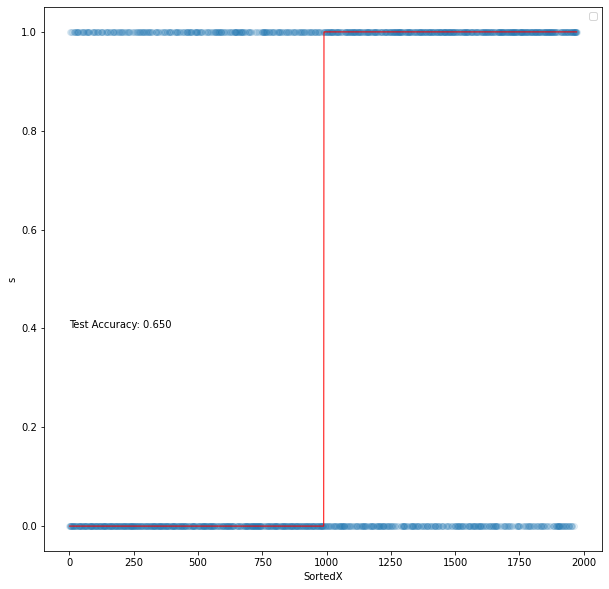

In [29]:
import tensorflow as tf 
import tensorflow.keras as keras


def filter(df):
    df = df.sort_values("s")
    xy = df.drop(['stdPBR', 'cumulative_vids'], axis = 1)
    #print(xy.head(5))
    xy = xy.to_numpy()
    
    # balance the number of 0 values and 1 values
    y_1 = np.argwhere(xy[:, -1] == 1).flatten()
    y_0 = np.argwhere(xy[:, -1] == 0).flatten()
    reduct = min(y_1.size, y_0.size)
    np.random.shuffle(y_1)
    np.random.shuffle(y_0)
    y_1 = y_1[0: reduct]
    y_0 = y_0[0: reduct]
    yidx = np.concatenate([y_0, y_1], axis = 0).flatten()
    np.random.shuffle(yidx)
    xy = xy[yidx, :]
    #print(mode(xy[:, -1]), np.median(xy[:, -1]))
    return xy

# need to balnce so there are the same number of 0 points as 1 points
def test_train(x_yarr, offset = 0, x_split = 0.9, nshuffles = 1, x_cols = 1, label_cols = -1, norm = True):
    for i in range(nshuffles):
        np.random.shuffle(x_yarr)
    
    print(x_yarr)
    if offset == 0:
        train_size = int(x_yarr.shape[0] * x_split)
        train_data = x_yarr[:train_size]
        test_data = x_yarr[train_size:]
    else:
        test_size = int(x_yarr.shape[0] * (1 - x_split))
        test_data = x_yarr[offset * test_size:(offset + 1) * test_size]
        train_data = np.array(x_yarray, copy = True)
        train_data = np.delete(train_data, slice(offset * test_size, (offset + 1) * test_size), axis = 0)
    
    if norm:
        x_train, m_t, s_t = normalize(train_data[:, 1:-1])
        x_test, m_t , s_t = normalize(test_data[:,1:-1], m_t, s_t)
        test_data[:,1:-1] = x_test
        # print(x_train[:, -1])
    else:
        x_train = train_data[:, 1:-1]
        x_test = test_data[:, 1:-1]
        m_t = None
        s_t = None
        # print(x_train[:, -1].shape)
        # print(train_data.shape[0])
        
    y_train = train_data[:, label_cols]
    y_test = test_data[:, label_cols]
    return x_train, x_test, y_train, y_test, test_data, m_t, s_t

def mse(y,y_pred):
    error = float(np.sum(np.square(y - y_pred)))/(np.shape(y)[0])
    return error

def one_hot_encode(arr):
    a = []
    for value in arr:
        if value == 0:
            a.append(1)
        else:
            a.append(0)
    a = np.array(a)
    
    # print(arr.shape)
    # print(a.shape)
    
    arr = np.expand_dims(arr, axis = 1)
    a = np.expand_dims(a, axis = 1)
    
    arr = np.concatenate([arr, a], axis = -1)
    return np.array(arr)

dft = readdata2("helpme.csv")
x_yarr = filter(dft)
# print(x_yarr)
x_train, x_test, y_train, y_test, test_full, train_mean, train_std = test_train(x_yarr, norm = True)
y_train = y_train.astype('int')
#print(x_train)
y_train = one_hot_encode(y_train)
y_test = y_test.astype('int')
y_test = one_hot_encode(y_test)

x_train = tf.convert_to_tensor(x_train, dtype = tf.float64)
x_test = tf.convert_to_tensor(x_test, dtype = tf.float64)
y_train = tf.convert_to_tensor(y_train, dtype = tf.float64)
y_test = tf.convert_to_tensor(y_test, dtype = tf.float64)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(y_train[0:5])


# model = keras.Sequential([
#     keras.layers.Dense(x_train.shape[-1], input_shape = (x_train.shape[-1],)),
#     keras.layers.Dense(512, activation = 'relu'), 
#     keras.layers.Dense(256, activation = 'relu'),
#     keras.layers.Dense(128, activation = 'relu'),
#     keras.layers.Dense(64, activation = 'relu'),
#     keras.layers.Dense(2, activation = 'softmax'),
# ])

# loss = keras.losses.CategoricalCrossentropy(from_logits=True)
# model.compile(optimizer = keras.optimizers.Adam(), loss = loss, metrics = [keras.metrics.CategoricalAccuracy()])
# model.fit(x = x_train, y = y_train, epochs = 100, verbose = 1, validation_data = (x_test, y_test), batch_size = 10)
print(model.summary())
y_trpred = model.predict(x_train)
y_pred = model.predict(x_test)

l = test_full[np.argsort(test_full[:, -1]), :]
l2 = tf.convert_to_tensor(l[:, 1:-1], dtype = tf.float64)
y_line = model.predict(l2)
y_line = np.array(y_line)
y_line = np.argmax(y_line, axis = 1).flatten()
y_line[y_line == 0] = 2
y_line[y_line == 1] = 0
y_line[y_line == 2] = 1

fig = plt.figure(figsize = (10,10))
ind = np.linspace(0, y_line.shape[-1] - 1, num = y_line.shape[-1])
plt.plot(ind, l[:, -1], linewidth=1, color="red")
plt.text(0.05, 0.4, 'Test Accuracy: %.3f' % 0.65)
plt.scatter(ind, y_line, alpha=0.1)
plt.xlabel("SortedX")
plt.ylabel("s")
plt.legend()
plt.show()